# Финальный проект. Телеком.

## Задача проекта:
Научиться прогнозировать отток киентов оператора связи «Ниединогоразрыва.ком». 

## Данные:
Персональные данные о некоторых клиентах, информация об их тарифах и договорах из разных источников:

* `contract.csv` — информация о договоре;
* `personal.csv` — персональные данные клиента;
* `internet.csv` — информация об интернет-услугах;
* `phone.csv` — информация об услугах телефонии.

## Услуги оператора 

**1. Стационарная телефонную связь.** Несколько линий одновременно.

**2. Интернет.** Подключение:
* через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или 
* оптоволоконный кабель (*Fiber optic*).  

Дополнительные услуги:

* Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
* Выделенная линия технической поддержки (*TechSupport*);
* Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
* Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

Оплата:
* ежемесячно
* договор на 1–2 года

Приступим к работе с данными. Импортируем необходимые библиотеки.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
! pip install phik
# ! pip install catboost
# ! pip install shap

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# ! gdown --id 1wTghk6VxzPsWUXvJAMXlC5YfvosFNTGw
# ! gdown --id 1Cn61pAI51RONGsOfz_3JtEEdDQQ04BGK
# ! gdown --id 1etAzqAblDKdyBImGJn_aa7o-GTvKz1Ho
# ! gdown --id 1dSOLCQTFYEJIp4XzRmxAAsgCmXz-pTrO

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1wTghk6VxzPsWUXvJAMXlC5YfvosFNTGw
To: /content/contract.csv
100% 546k/546k [00:00<00:00, 89.9MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Cn61pAI51RONGsOfz_3JtEEdDQQ04BGK
To: /content/internet.csv
100% 221k/221k [00:00<00:00, 91.2MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder,OneHotEncoder
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier

Загрузим данные из имеющихся источников. 

In [4]:
try:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')
except FileNotFoundError:
    df_contract = pd.read_csv('contract.csv')
    df_personal = pd.read_csv('personal.csv')
    df_internet = pd.read_csv('internet.csv')
    df_phone = pd.read_csv('phone.csv')

Посмотрим с чем имеем дело. Посмотрим, что имеем в df_contract. 

In [5]:
df_contract.head()

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65

В df_contract указаны данные по работе системе работы с клиентом:
* **customerID** - код клиента
* **BeginDate** - дата, когда пользователь стал клиентом оператора
* **EndDate** - дата указана не везде. Значение No указывает на то, что клиент продолжает сотрудничество. Тогда так указанная дата означает дату ухода клиента.
* **Type** - Тип оплаты. 
* **PaperlessBilling** - безналичный расчет. Значения да или нет.  
* **PaymentMethod** - оплата по электронному чеку, отправлен чеку или переводом.
* **MonthlyCharges** - ежемесячная оплата.
* **TotalCharges** - всего оплачено.

In [6]:
df_personal.head()

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

В df_personal находятся личные данные клиентов:
* **customerID** - код клиента
* **gender** - пол клиента
* **SeniorCitizen** - пенсионер 
* **Partner** - партнер, значения да или нет. Возможно, это значение женат\замужем.
* **Dependents** - иждивенцы, значения да или нет. Есть дети или нет. Наверное, это имеется ввиду.  

In [7]:
df_internet.head()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

В df_internet данные по использованию интернета и доп услуг:
* **customerID** - код клиента
* **InternetService** - подключение через телефонную линию DSL или оптоволоконный кабель Fiber optic.
* **OnlineSecurity** - блокировка небезопасных сайтов. Значение есть или нет.
* **OnlineBackup** - облачное хранилище файлов для резервного копирования данных. Значение есть или нет. 
* **DeviceProtection** -  антивирус. Значение есть или нет.
* **TechSupport** - выделенная линия технической поддержки. Значение есть или нет.
* **StreamingTV** - стриминговое телевидение. Значение есть или нет.  
* **StreamingMovies** - каталог фильмов. Значение есть или нет.

In [8]:
df_phone.head()

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

В df_phone данные о стационарной телефонной связи:
* **customerID** - код клиента
* **MultipleLines** - наличие или отсутствие нескольких линий одновременно.

Данные посмотрели. Приступим к их анализу.

## Анализ данных

Для удобства создадим список выборок + список названий.

In [9]:
dfs = [df_contract, df_personal, df_internet, df_phone]
dfs_names = ['df_contract', 'df_personal', 'df_internet', 'df_phone']

Посмотрим на кол-во записей в выборках.

In [10]:
dfs_len=[]
for i in range(len(dfs)):
    dfs_len.append(len(dfs[i]))
len_dfs = pd.DataFrame(data=dfs_len, index=dfs_names, columns=['df_len'])
len_dfs

df_len
df_contract    7043
df_personal    7043
df_internet    5517
df_phone       6361

**Вывод по длине выборок** В contract и personal у нас одинаковое колличество клиентов. В данных по пользователям интернета и стационарного телевона данных значительно меньше. Что логично, таким типом связи клиенты не пользуются.

### Пропуски в данных

Посмотрим на пропуски в данных.

In [11]:
for i in range(len(dfs)):
    print(dfs_names[i])
    print(dfs[i].isna().mean())
    print()

df_contract
customerID          0.0
BeginDate           0.0
EndDate             0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
dtype: float64

df_personal
customerID       0.0
gender           0.0
SeniorCitizen    0.0
Partner          0.0
Dependents       0.0
dtype: float64

df_internet
customerID          0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
dtype: float64

df_phone
customerID       0.0
MultipleLines    0.0
dtype: float64



**Вывод по пропускам в данных** Пропусков в данных нет. 

### Корректировка названий столбцов

Нужно привести названия к нижнему регистру.

In [12]:
for df in dfs:
    df.columns = df.columns.str.lower()
    print(df.columns)
    print()
    

Index(['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges'],
      dtype='object')

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents'], dtype='object')

Index(['customerid', 'internetservice', 'onlinesecurity', 'onlinebackup',
       'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies'],
      dtype='object')

Index(['customerid', 'multiplelines'], dtype='object')



### Проверка на дубликаты

In [13]:
for i in range(len(dfs)):
    print()
    print(dfs_names[i])
    print(dfs[i].duplicated().sum())


df_contract
0

df_personal
0

df_internet
0

df_phone
0


**Вывод по дубликаты в данных** Дубликаты в данных нет. 

### Проверка типов данных

In [14]:
for i in range(len(dfs)):
    print(dfs_names[i])
    print(dfs[i].dtypes)
    print()

df_contract
customerid           object
begindate            object
enddate              object
type                 object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
dtype: object

df_personal
customerid       object
gender           object
seniorcitizen     int64
partner          object
dependents       object
dtype: object

df_internet
customerid          object
internetservice     object
onlinesecurity      object
onlinebackup        object
deviceprotection    object
techsupport         object
streamingtv         object
streamingmovies     object
dtype: object

df_phone
customerid       object
multiplelines    object
dtype: object



**Вывод по типам данных** Все переменные кроме seniorcitizen и monthlycharges категориальные. Туда же мы можем отнести и seniorcitizen, но она у нас бинарна и принимает 0 или 1 тем самым отражая категорию пенсионер или нет. Переменная monthlycharges непрерывная. Тут нужно вносить изменения. 

 1. Нужно изменить тип данных в датах: begindate и enddate.   
 2. totalcharges как и monthlycharges должен быть float64.               

In [15]:
df_contract['enddate'].value_counts(normalize=True)

No                     0.734630
2019-11-01 00:00:00    0.068863
2019-12-01 00:00:00    0.066165
2020-01-01 00:00:00    0.065313
2019-10-01 00:00:00    0.065029
Name: enddate, dtype: float64

In [16]:
df_contract['begindate'] = pd.to_datetime(df_contract['begindate'])
df_contract['enddate'] = pd.to_datetime(df_contract['enddate'],errors='coerce')
df_contract['enddate'].value_counts()

2019-11-01    485
2019-12-01    466
2020-01-01    460
2019-10-01    458
Name: enddate, dtype: int64

Посмотрим на значения begindate

Text(0.5, 1.0, 'Распределение данных в признаке begindate')

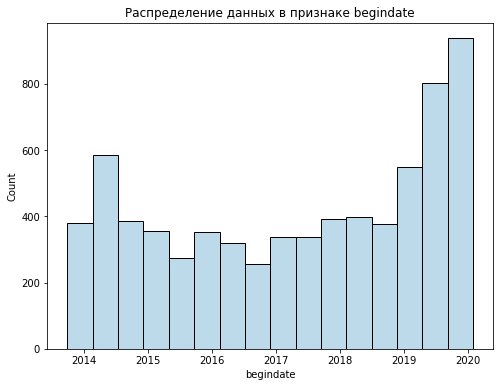

In [17]:
plt.figure(figsize=(8,6))
sns.set_palette('Paired')
sns.histplot(data=df_contract, x='begindate')
plt.title('Распределение данных в признаке begindate')

Даты начала договоров с 13 года по январь 20 года.

Text(0.5, 1.0, 'Распределение данных в признаке enddate')

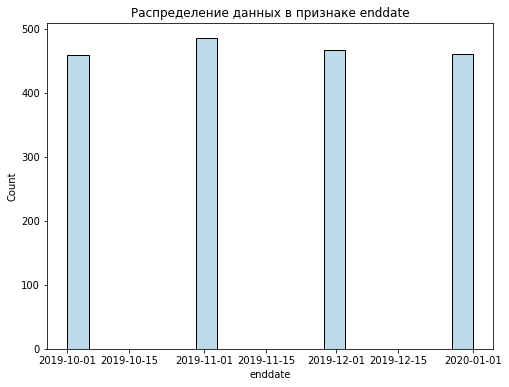

In [18]:
plt.figure(figsize=(8,6))
sns.set_palette('Paired')
sns.histplot(data=df_contract, x='enddate')
plt.title('Распределение данных в признаке enddate')

**Выводы по графикам** Судя по датам, клиенты уходили примерно в одинаковом колличестве 4 месяца до выгрузки. Это октябрь, ноябрь и декабь 2019 года + январь 2020 года. Данных по февралю 20 года у нас нет, так как данные выгружены 01.02.20г. Уходило немного менее 500 человек. Получается, что с октября 19 года, люди стали уходить. ВОзможно, у конкурента появилось какое-то выгодное предложение, либо наш сервис перестал устраивать. Может быть, были какие-то сбои.

Исправить тип в totalcharges сразу не получилось. ВИдимо в данных есть пробелы, возможно и прочие знаки. Почистим столбец и преобразуем в вещественный.

In [19]:
df_contract['totalcharges'] = df_contract['totalcharges'].replace(r'^\s*$', 0, regex=True)
df_contract['totalcharges'] = df_contract['totalcharges'].astype(float)

In [20]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           1869 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


Интересно посмотреть к какому типу оплаты и PaperlessBilling относятся такие клиенты. Для этого сгруппируем данные по типу оплату и посмотрим на значения по атрибутам monthlycharges, totalcharges.

            count       mean  median
enddate                             
2019-10-01    458  75.827948  80.325
2019-11-01    485  75.012887  80.200
2019-12-01    466  74.325536  79.575
2020-01-01    460  72.575435  76.225


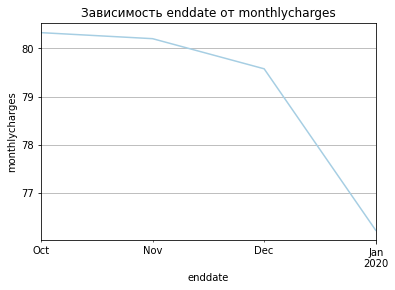

In [21]:
print(df_contract.groupby('enddate')['monthlycharges'].agg(['count','mean','median']))
sns.set_palette('Paired')
df_contract.groupby('enddate')['monthlycharges'].median().plot(title=('Зависимость enddate от monthlycharges'), 
                                                             ylabel='monthlycharges')

plt.grid()

Вывод по зависимости ухода от monthlycharges: получается, что уходили те, кто платить в среднем около 75 у.е. в месяц.

            count         mean   median
enddate                                
2019-10-01    458  1619.448035  833.125
2019-11-01    485  1440.232577  622.900
2019-12-01    466  1584.518348  732.925
2020-01-01    460  1487.655109  663.325


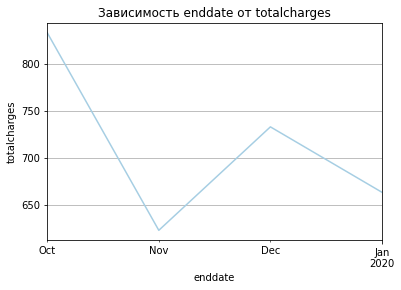

In [22]:
print(df_contract.groupby('enddate')['totalcharges'].agg(['count','mean','median']))
sns.set_palette('Paired')
df_contract.groupby('enddate')['totalcharges'].median().plot(title=('Зависимость enddate от totalcharges'), 
                                                             ylabel='totalcharges')
plt.grid()

Вывод по зависимости ухода от totalcharges: ушли в среднем те, кто успели воспользоваться услугами на сумму около 700 у.е.

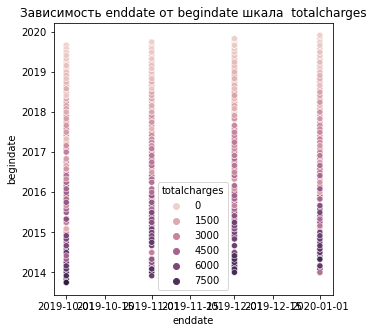

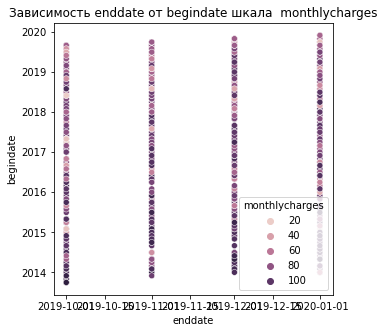

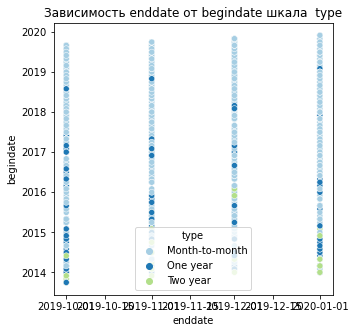

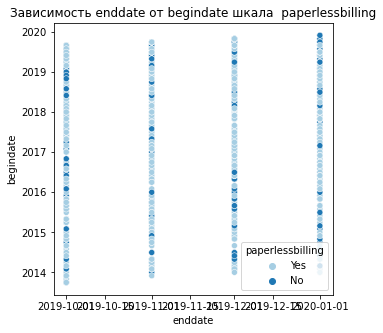

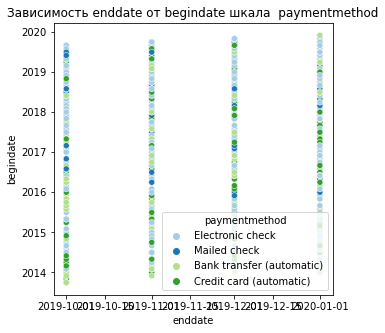

In [23]:
col = ['totalcharges','monthlycharges','type','paperlessbilling', 'paymentmethod']
for c in col:
    plt.figure(figsize=(5, 5))
    plt.title(f'Зависимость enddate от begindate шкала  {c}')
    sns.scatterplot(data=df_contract, x='enddate', y='begindate', hue=c)
    

**Выводы по зависимости тех, кто уходит от type,paymentmethod и paperlessbilling**
* Получается, что ежемесячная оплата самая дорогая. Это логично.Таких клиентов(кстати) большинство. И, похоже, уходят клиенты, которые платят ежемесячно. Медианы по расходам в месяц и total ближе всего именно к этим значениям. 
* Скорее всего это клиенты оплатой по Electronic check. 
* И те, кто получает электронный документ обоплате. 

### Аномалии в данных

Посмотрим на значения непрерывных переменных. Это totalcharges и monthlycharges.    

In [24]:
df_contract[['monthlycharges','totalcharges']].describe()

monthlycharges  totalcharges
count     7043.000000   7043.000000
mean        64.761692   2279.734304
std         30.090047   2266.794470
min         18.250000      0.000000
25%         35.500000    398.550000
50%         70.350000   1394.550000
75%         89.850000   3786.600000
max        118.750000   8684.800000

Минимумы monthlycharges и totalcharges совпадают. Получается, что есть клиенты, которые были клиентами оператора всего 1 месяц. 

Посмотрим на распределение значений.

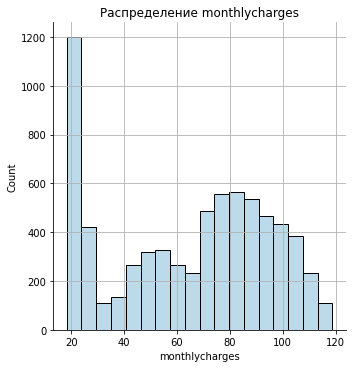

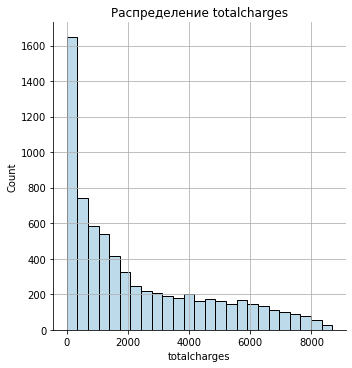

In [25]:
columns = ['monthlycharges','totalcharges']
for column in columns:
    sns.set_palette('Paired')  
    plot=sns.displot(df_contract[column])  
    plt.title(f'Распределение {column}')
    plt.grid()
    plt.show()

**Вывод** Средние ежемесячных расходов и общих затрат составляют, соответственно, 64.76 и 2283.30 у.е. Серьезный пик в ежемесячнх оплатах находится в значении около 20 у.е. А в общих затратах у 20. Посмотрим на эти значения.

<Figure size 1440x1440 with 0 Axes>

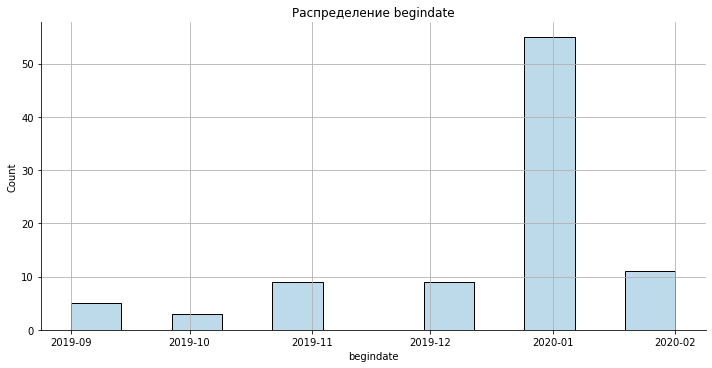

<Figure size 1440x1440 with 0 Axes>

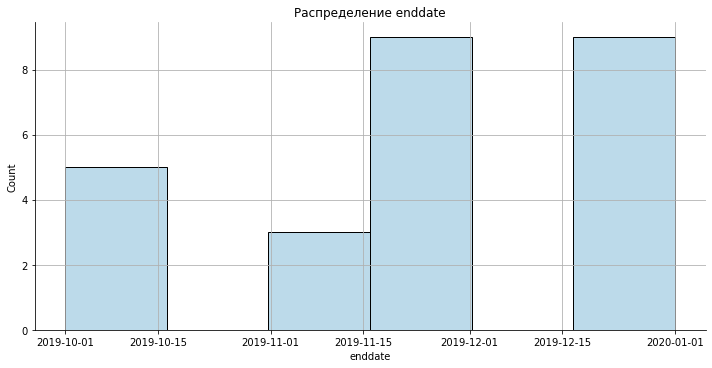

<Figure size 1440x1440 with 0 Axes>

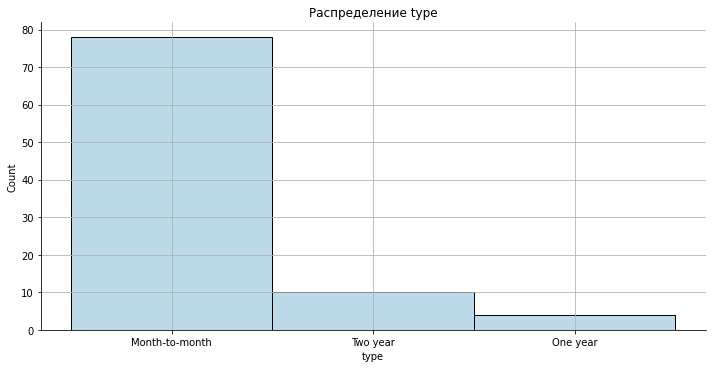

<Figure size 1440x1440 with 0 Axes>

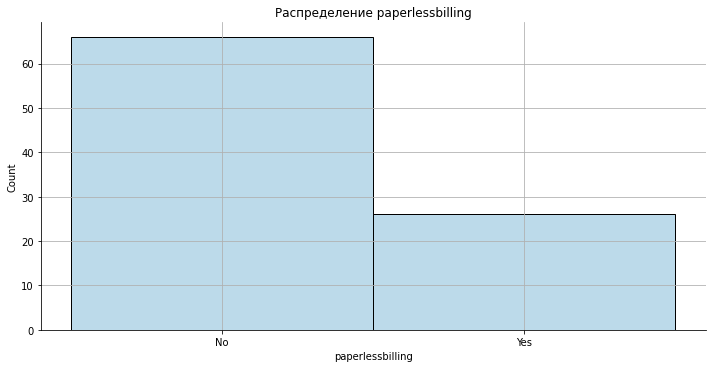

<Figure size 1440x1440 with 0 Axes>

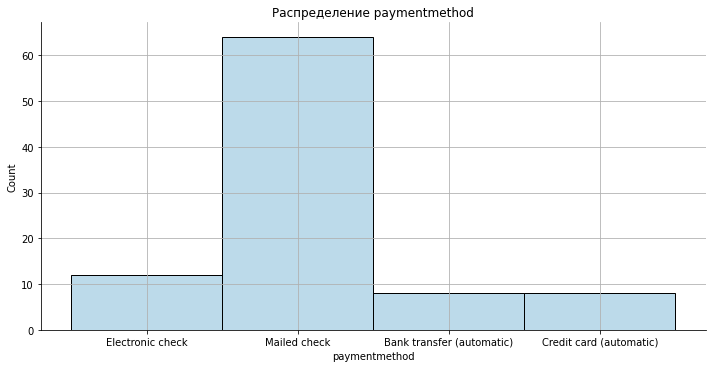

<Figure size 1440x1440 with 0 Axes>

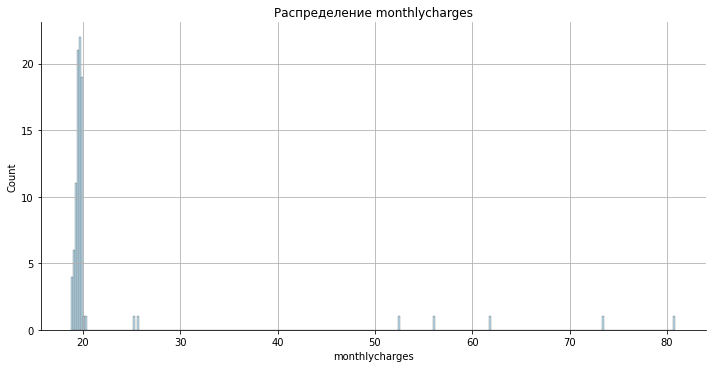

<Figure size 1440x1440 with 0 Axes>

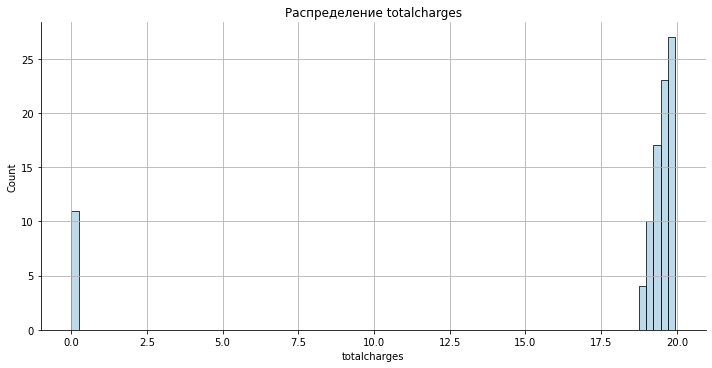

In [26]:
dfc = df_contract.query('totalcharges<20')
dfc_col = [ 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges']
for c in dfc_col: 
    plt.figure(figsize=(20, 20))
    sns.displot(dfc[c], aspect=2)
    sns.set_palette('Paired')
    plt.title(f'Распределение {c}')
    plt.grid()
    plt.show()    

Получается, что это новые клиенты, пришедшие в последние месяцы. Большинство из них фоормили ежемесячную оплату. Без электронного документа об оплате. А способ оплаты по чеком по почте. Ежемесячный платеж для этих клиентов был до 20 у.е. КОмпания получила до 20 у.е. Так как елиенты обслуживалиссь соответственно 1 месяц. 

Посмотрим на распределение категориальных признаков.

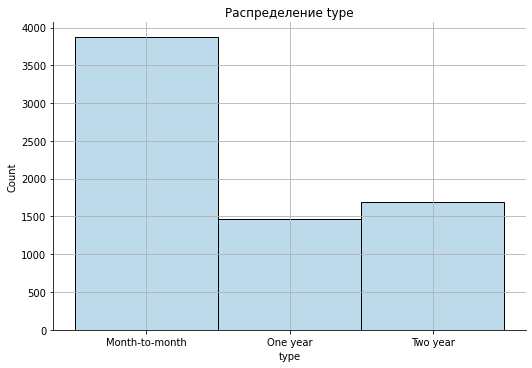

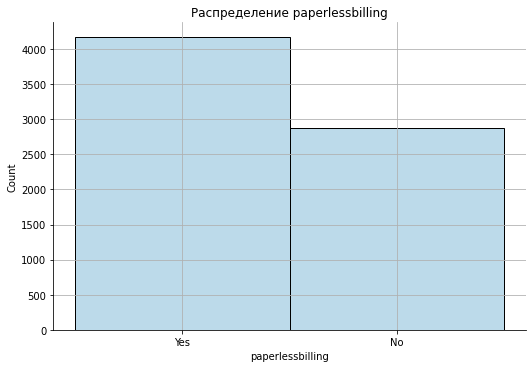

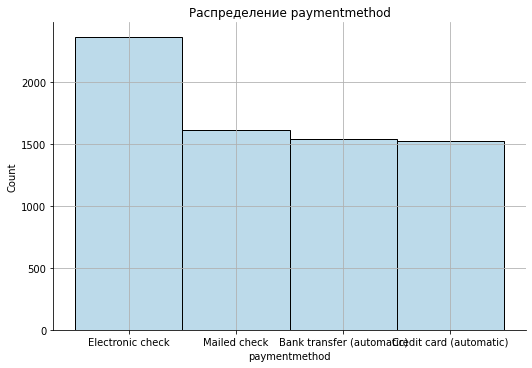

In [27]:
df_contract_cat = ['type', 'paperlessbilling', 'paymentmethod']
for cat in df_contract_cat:
    sns.displot(df_contract[cat], aspect=1.5)
    sns.set_palette('Paired')
    plt.title(f'Распределение {cat}')
    plt.grid()
    plt.show() 

**Категориальные признаки в df_contract**: 
* **Тип оплаты** 55% все договоров оформлены с ежемесячной оплатой. 20% с оплатой ежегодной. И 24% с оплатой раз в 2 года.
* **Электронный документ об оплате** Практически 60% получают чеки, тогда как 40% они не требуются.
* **Способ оплаты** лидером по оплатам - 33% занимают электронные квитанции. Остальные способы оплаты популярны в равной степени. Около 21-22%: почтовые квитанции, автоматические оплаты с карт и банковские переводы. 

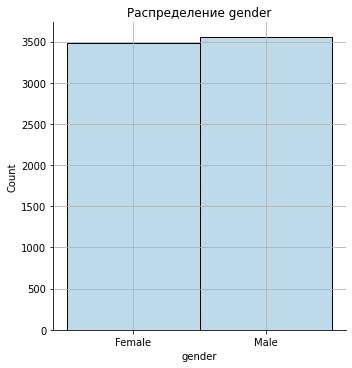

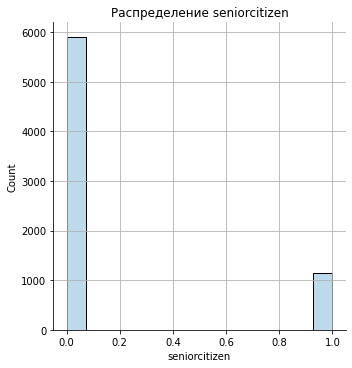

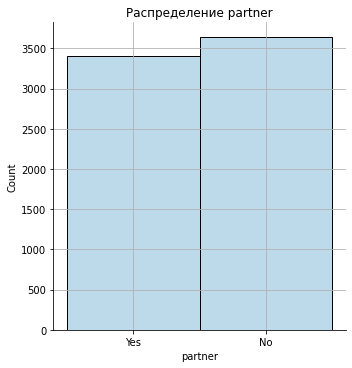

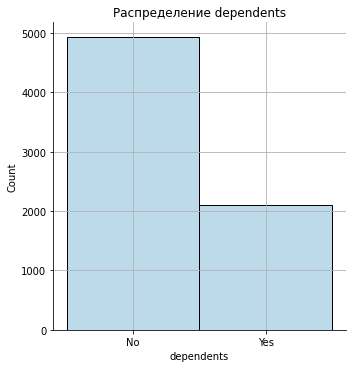

In [28]:
df_personalt_cat = ['gender', 'seniorcitizen', 'partner', 'dependents']
for cat in df_personalt_cat:
    sns.displot(df_personal[cat])
    sns.set_palette('Paired')
    plt.title(f'Распределение {cat}')
    plt.grid()
    plt.show() 


**Категориальные признаки в df_personal**: 
* **Пол** Деление по полам примерно равнозначное. 50% женщин и 50% мужчин.
* **Электронный документ об оплате** Практически 60% получают чеки, тогда как 40% они не требуются.
* **Способ оплаты** лидером по оплатам - 33% занимают электронные квитанции. Остальные способы оплаты популярны в равной степени. Около 21-22%: почтовые квитанции, автоматические оплаты с карт и банковские переводы. 

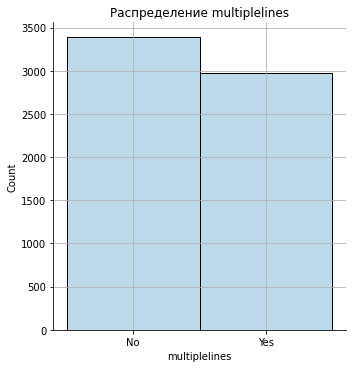

In [29]:
sns.displot(df_phone['multiplelines'])
sns.set_palette('Paired')
plt.title(f'Распределение multiplelines')
plt.grid()
plt.show() 

**Категориальные признаки в df_phone**: 
* **Возможность ведения параллельных линий во время звонка** 47% пользователей имеют такую возможность.

In [30]:
df_internet_cat = ['internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection','techsupport','streamingtv', 'streamingmovies']
for cat in df_internet_cat:
    print(cat)
    print(df_internet[cat].value_counts(normalize=True))
    print()

internetservice
Fiber optic    0.561175
DSL            0.438825
Name: internetservice, dtype: float64

onlinesecurity
No     0.63404
Yes    0.36596
Name: onlinesecurity, dtype: float64

onlinebackup
No     0.559724
Yes    0.440276
Name: onlinebackup, dtype: float64

deviceprotection
No     0.560993
Yes    0.439007
Name: deviceprotection, dtype: float64

techsupport
No     0.629509
Yes    0.370491
Name: techsupport, dtype: float64

streamingtv
No     0.509335
Yes    0.490665
Name: streamingtv, dtype: float64

streamingmovies
No     0.504803
Yes    0.495197
Name: streamingmovies, dtype: float64



**Категориальные признаки в df_internet**: 
* **Подключение интернета** подключение через оптоволоконный кабель Fiber optic у 56% пользователей, у остальных через телефонную линию DSL. 

Не более 50% пользователей подключены к доп услугам:
* **Блокировка небезопасных сайтов** есть только у 36% пользователей.
* **Облачное хранилище файлов** и **Антивирус** есть только у 44% пользователей.
* **Выделенная линия технической поддержки** есть только у 37% пользователей.
* **Стриминговое телевидение** и **Каталог фильмов** более популярны и практически 50% пользуются этой услугами.

План работы следующий:
1. Сделать таргет, присвоив 0 там, где нет enddate. Там же, где дата указана будет 0.
2. Судя по значениям в  enddate 0.73 -это 0. Будем добавлять объекты 1 класса.  
3. Преобразуем кат признаки с помощью One-hot-Recoreder.
4. Разделим выборки на тренировочную, тестовую и валидационную.
5. Изучим корреляцию признаков. Возможно, подготовим новые. 
6. Выберем признакми для загрузки в модель. Будем экспериментировать с признаками, чтобы добиться необъодимо значения метрики ROC AUC.

Вопросов, кажется нет. Наверняка возникнут в ходе работы.

## Объединение данных

In [31]:
df_ = df_personal.merge(df_contract, on='customerid', how='left')
df__ = df_.merge(df_internet, on='customerid', how='left')
df = df__.merge(df_phone, on='customerid', how='left')

Посмотрим список признаков в df.

In [32]:
df.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'begindate', 'enddate', 'type', 'paperlessbilling', 'paymentmethod',
       'monthlycharges', 'totalcharges', 'internetservice', 'onlinesecurity',
       'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv',
       'streamingmovies', 'multiplelines'],
      dtype='object')

Проверим число пользователей.

In [33]:
len(df)

7043

Все сходится. Значит, ничего не потеряли. 

### Работа со столбцом Enddate.

Значение в Enddate соответствует дате потери клиента. Данные выгружали первое февраля 2020 года. Сделаем новый признак длительность контракта 
contract duration как разницу между begindate и enddate. для этого, там, где не указано даты - укажем 1.02.20.

In [34]:
df['enddate'] = df['enddate'].fillna(pd.Timestamp('2020-02-01'))
df['enddate'].value_counts(normalize=True) 

2020-02-01    0.734630
2019-11-01    0.068863
2019-12-01    0.066165
2020-01-01    0.065313
2019-10-01    0.065029
Name: enddate, dtype: float64

В дальнейшем мы не будем использовать даты начала сотрудничества и ухода, но мы можем оставить год. Возможно, он поможет в обучении. Ведь по анализу данных мы видели тенеденцию к уходу новых клиентов.

In [35]:
df['contract_duration'] = (df['enddate']-df['begindate']) 
df['contract_duration'] = df['contract_duration'].dt.days
df['year_in'] = (pd.DatetimeIndex(df['begindate']).year)

Наш целевой признак - уход клиента. Для тех клиентов где был изначально указан enddate нужно присвоить значение таргета - 1. Там же, где не было указано даты ухода укажем в таргете 0.

In [36]:
df['y_true'] = df['enddate'].apply(lambda x: 0 if x == pd.Timestamp('2020-02-01') else 1)
df['y_true'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: y_true, dtype: float64

In [37]:
df=df.drop(['enddate','begindate'],axis=1)

### Пропуски в данных

In [38]:
df.isna().mean()

customerid           0.000000
gender               0.000000
seniorcitizen        0.000000
partner              0.000000
dependents           0.000000
type                 0.000000
paperlessbilling     0.000000
paymentmethod        0.000000
monthlycharges       0.000000
totalcharges         0.000000
internetservice      0.216669
onlinesecurity       0.216669
onlinebackup         0.216669
deviceprotection     0.216669
techsupport          0.216669
streamingtv          0.216669
streamingmovies      0.216669
multiplelines        0.096834
contract_duration    0.000000
year_in              0.000000
y_true               0.000000
dtype: float64

Пропуски в данных у 21.6% пользователей в след признаках:internetservice, onlinesecurity, onlinebackup,deviceprotection,techsupport,streamingtv, streamingmovies, multiplelines. Данных нет, так как пользователь не пользуется услугой. Все пустые значения заполним No. У totalcharges также есть нули, но это, видимо, те пользователи, которые недавно появились(менее месяца). Эти значения трогать не будем.

In [39]:
df[['internetservice', 'onlinesecurity', 'onlinebackup','deviceprotection','techsupport','streamingtv', 'streamingmovies', 
    'multiplelines']] = df[['internetservice', 'onlinesecurity', 'onlinebackup','deviceprotection','techsupport',
                            'streamingtv', 'streamingmovies', 'multiplelines']].fillna('No')                   

In [40]:
df.isna().mean()

customerid           0.0
gender               0.0
seniorcitizen        0.0
partner              0.0
dependents           0.0
type                 0.0
paperlessbilling     0.0
paymentmethod        0.0
monthlycharges       0.0
totalcharges         0.0
internetservice      0.0
onlinesecurity       0.0
onlinebackup         0.0
deviceprotection     0.0
techsupport          0.0
streamingtv          0.0
streamingmovies      0.0
multiplelines        0.0
contract_duration    0.0
year_in              0.0
y_true               0.0
dtype: float64

## Деление выборки.

In [41]:
train, test = train_test_split(df, test_size=0.25, random_state=31022, stratify=df['y_true'])

In [42]:
train['y_true'].mean()

0.2654297614539947

In [43]:
test['y_true'].mean()

0.26519023282226006

**Вывод по делению выборок.** Баланс класов при разделении выборок соблюден.

<div class="alert alert-warning">
<b>**Комментарий тимлида ⚠️:**</b>

Лучше проводить разбиение на трейн-тест ПОСЛЕ анализа корреляции и работы с признаками. Возможно в ходе анализы ты решишь убрать/добавить новые признаки, тогда придется заново разбивать выборку.
</div>

## Поиск связей. Корреляция признаков.

### Коэффициент корреляции Пирсона.

Посмотрим на коэффициент корреляции Пирсона.

In [44]:
corr_matrix = train.corr()

Посмотрим насколько каждый атрибут связан с уходом клиента от оператора.

In [45]:
corr_matrix['y_true'].sort_values(ascending=False)

y_true               1.000000
year_in              0.282807
monthlycharges       0.194573
seniorcitizen        0.163432
totalcharges        -0.194881
contract_duration   -0.343895
Name: y_true, dtype: float64

**Вывод по Пирсону** Коэффициент Пирсона отражает корреляцию только численных атрибутов. Наибольшей связью с уходом клиентов обладает contract_duration. Вычисленный как время обслуживания клиента. 

### Коэффициент phik.

Применим Phik для оценки корреляции признаков. Что важно, он рассматривает не только числовые, но и категориальные атрибуты.

In [46]:
phik_overview = train.phik_matrix()

interval columns not set, guessing: ['seniorcitizen', 'monthlycharges', 'totalcharges', 'contract_duration', 'year_in', 'y_true']


/usr/local/lib/python3.7/dist-packages/phik/data_quality.py:62: UserWarning: The number of unique values of variable customerid is large: 5282. Are you sure this is not an interval variable? Analysis for pairs of variables including customerid can be slow.
  col, df[col].nunique()


In [47]:
phik_overview['y_true'].sort_values(ascending=False)

customerid           1.000000
y_true               1.000000
contract_duration    0.462353
paymentmethod        0.462098
monthlycharges       0.354175
year_in              0.348037
paperlessbilling     0.309623
totalcharges         0.273188
techsupport          0.252553
seniorcitizen        0.252168
dependents           0.249871
type                 0.247579
onlinesecurity       0.245887
partner              0.222036
internetservice      0.197782
onlinebackup         0.135824
deviceprotection     0.102760
streamingtv          0.099400
streamingmovies      0.098003
multiplelines        0.071226
gender               0.018336
Name: y_true, dtype: float64

**Вывод по Phik** тут мы также видим, что наибольшей связью с уходом клиента является contract_duration. Однако он несколько выше, чем при оценке коэффициентом Пирсона: 0.467 против 0.35. Тут также появился атрибут paymentmethod(тип оплаты) с коэффициентом 0.455, monthlycharges phik оценивает значительно выше и это 0.359. Делее идут paperlessbilling, totalcharges, onlinesecurity и techsupport.  

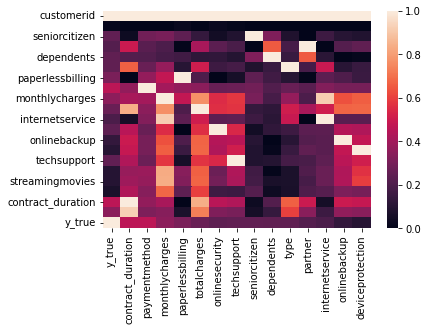

In [48]:
ax = sns.heatmap(phik_overview[['y_true', 'contract_duration', 'paymentmethod',
                                'monthlycharges','paperlessbilling','totalcharges','onlinesecurity',
                                'techsupport','seniorcitizen', 'dependents','type','partner','internetservice',
                                'onlinebackup','deviceprotection']])

В качестве сокращенного списка признаков будем использовать этот набор. Здесь коэффициент достаточно высок, чтобы учесть влияние в обучении.

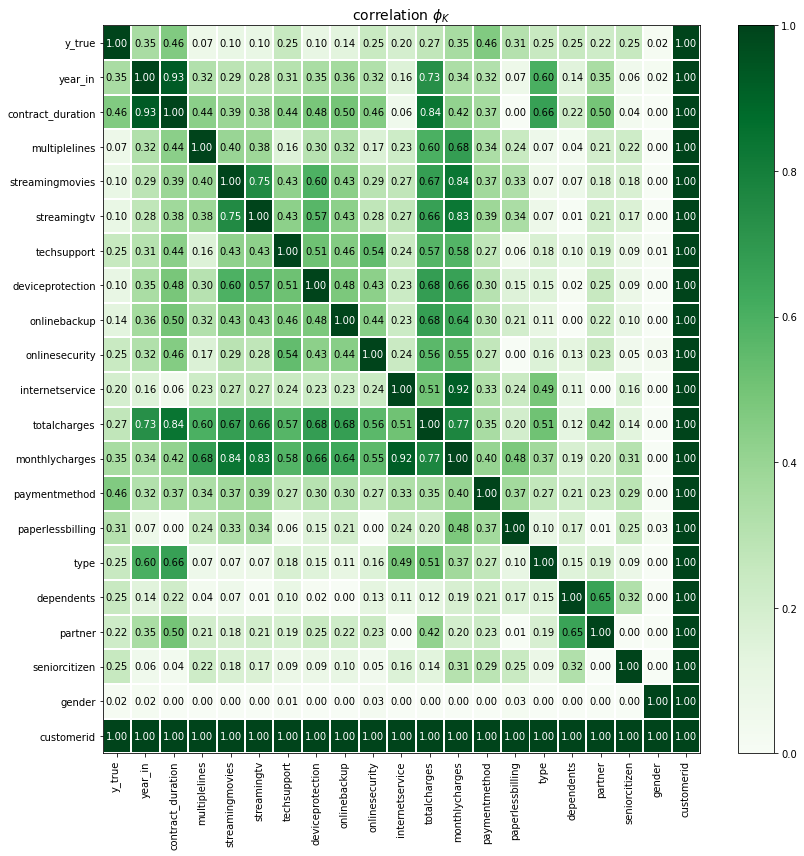

In [49]:
from phik.report import plot_correlation_matrix

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(12, 12)) 
plt.tight_layout()

## Машинное обучение

### CatBoost на всех фичах.

Попробуем запустить CatBoost на всех признаках, а потом на выбранном наборе и сравним результат. 

In [50]:
train_full = train.copy()

In [51]:
train_full = train_full.drop('customerid',axis=1)

Разделим признаки по типам данных. 

In [52]:
train_full.columns

Index(['gender', 'seniorcitizen', 'partner', 'dependents', 'type',
       'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges',
       'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines',
       'contract_duration', 'year_in', 'y_true'],
      dtype='object')

Разобъем принаки на категориальные и числянные. 

In [53]:
x = ['gender', 'seniorcitizen', 'partner', 'dependents', 'type',
       'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges',
       'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines',
       'contract_duration']

y = ['y_true']

cat_feat = ['gender', 'seniorcitizen', 'partner', 'dependents', 'type', 'paperlessbilling', 'paymentmethod', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']

Добавим валидационную выборку.

In [54]:
train_o, val_o = train_test_split(train_full, train_size=0.8, random_state=31022, stratify=train_full['y_true'])
print(len(val_o.columns))
print(len(train_o.columns))

20
20


In [55]:
val_o.columns

Index(['gender', 'seniorcitizen', 'partner', 'dependents', 'type',
       'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges',
       'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines',
       'contract_duration', 'year_in', 'y_true'],
      dtype='object')

In [56]:
train_o.columns

Index(['gender', 'seniorcitizen', 'partner', 'dependents', 'type',
       'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges',
       'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines',
       'contract_duration', 'year_in', 'y_true'],
      dtype='object')

Проверим, насколько верно разделили выборки на обучающую, валидационную и тестовую.

In [57]:
len(val_o)/len(df)

0.15007809172227743

In [58]:
len(train_o)/len(df)

0.5998864120403238

In [59]:
len(test)/len(df)

0.25003549623739885

Зададим параментры для запуска CatBoost.

In [60]:
params = {'loss_function' : 'Logloss',
'eval_metric' : 'AUC',
'verbose' : 200,
'auto_class_weights':'Balanced',
'random_seed' : 31022,
'custom_metric' : 'AUC:hints=skip_train~false',
'learning_rate': 0.001}

In [61]:
model_cat = CatBoostClassifier(**params)

In [62]:
train_data = Pool(data=train_o[x],
                  label=train_o[y],
                  cat_features=cat_feat
                 )

valid_data = Pool(data=val_o[x],
                  label=val_o[y],
                  cat_features=cat_feat
                 )

In [63]:
model_cat.fit(train_data, eval_set=valid_data)


0:	learn: 0.8228261	test: 0.8345540	best: 0.8345540 (0)	total: 86.4ms	remaining: 1m 26s
200:	learn: 0.8419669	test: 0.8539091	best: 0.8566859 (71)	total: 4.39s	remaining: 17.4s
400:	learn: 0.8437165	test: 0.8553399	best: 0.8566859 (71)	total: 7.83s	remaining: 11.7s
600:	learn: 0.8454759	test: 0.8567340	best: 0.8568670 (574)	total: 9.53s	remaining: 6.33s
800:	learn: 0.8477751	test: 0.8581603	best: 0.8581832 (796)	total: 11.2s	remaining: 2.78s
999:	learn: 0.8506444	test: 0.8600039	best: 0.8600039 (999)	total: 12.9s	remaining: 0us

bestTest = 0.8600038522
bestIteration = 999



Создадим списки для сохранения моделей и результатов.

In [64]:
models_list=[]
models_results=[]

In [65]:
models_results.append(model_cat.get_best_score()['validation']['AUC'])
models_list.append(model_cat)

### CatBoost на части фичей.

Выберем часть признаков и попробуем запустить обучение на них.

In [66]:
train_part = train.copy()

In [67]:
train_part = train[['y_true', 'contract_duration', 'paymentmethod', 'monthlycharges','paperlessbilling','totalcharges','onlinesecurity',
                    'techsupport','seniorcitizen', 'dependents','type','partner','internetservice', 'onlinebackup','deviceprotection']]
                               

In [68]:
train_part.select_dtypes(include='int64').columns

Index(['y_true', 'contract_duration', 'seniorcitizen'], dtype='object')

In [69]:
train_part.select_dtypes(include='float64').columns

Index(['monthlycharges', 'totalcharges'], dtype='object')

In [70]:
train_part.select_dtypes(include='object').columns

Index(['paymentmethod', 'paperlessbilling', 'onlinesecurity', 'techsupport',
       'dependents', 'type', 'partner', 'internetservice', 'onlinebackup',
       'deviceprotection'],
      dtype='object')

In [71]:
x = [ 'contract_duration', 'paymentmethod', 'monthlycharges','paperlessbilling','totalcharges','onlinesecurity', 'techsupport',
     'seniorcitizen', 'dependents','type','partner','internetservice', 'onlinebackup','deviceprotection']

cat_features2 = ['paymentmethod', 'paperlessbilling', 'onlinesecurity', 'techsupport',
       'dependents', 'type', 'partner', 'internetservice', 'onlinebackup',
       'deviceprotection']
y = ['y_true']

In [72]:
train_best, val_best = train_test_split(train_part, train_size=0.8, random_state=31022, stratify=train['y_true'])
print(len(train_best.columns))
print(len(val_best.columns))

15
15


In [73]:
params = {'loss_function' : 'Logloss',
'eval_metric' : 'AUC',
'verbose' : 200,
'auto_class_weights':'Balanced',
'random_seed' : 31022,
'custom_metric' : 'AUC:hints=skip_train~false',
'learning_rate': 0.001}

In [74]:
train_data = Pool(data=train_best[x],
                  label=train_best[y],
                  cat_features=cat_features2
                 )

valid_data = Pool(data=val_best[x],
                  label=val_best[y],
                  cat_features=cat_features2
                 )

In [75]:
model_cat = CatBoostClassifier(**params)

In [76]:
model_cat.fit(train_data, eval_set=valid_data)


0:	learn: 0.8015235	test: 0.8227290	best: 0.8227290 (0)	total: 7.56ms	remaining: 7.56s
200:	learn: 0.8375112	test: 0.8536316	best: 0.8543058 (191)	total: 1.74s	remaining: 6.92s
400:	learn: 0.8401875	test: 0.8570344	best: 0.8570344 (399)	total: 3.43s	remaining: 5.13s
600:	learn: 0.8443853	test: 0.8578668	best: 0.8579585 (598)	total: 5.06s	remaining: 3.36s
800:	learn: 0.8461088	test: 0.8590568	best: 0.8591898 (791)	total: 6.79s	remaining: 1.69s
999:	learn: 0.8481975	test: 0.8599053	best: 0.8599970 (978)	total: 8.53s	remaining: 0us

bestTest = 0.8599969733
bestIteration = 978

Shrink model to first 979 iterations.


In [77]:
models_results.append(model_cat.get_best_score()['validation']['AUC'])
models_list.append(model_cat)

## Кодирование категориальных признаков.


В данных 2 напрерывных признака monthlycharges и totalcharges. Необходимо провести масштабирование, так как диапазон значений значительно отличается.
Признаки: gender, partner, dependents, type, paperlessbilling, object, paymentmethod, internetservice, onlinesecurity, onlinebackup, deviceprotection, techsupport, streamingtv, streamingmovies, multiplelines - категориальные. Не все модели машинного обучения могут работать с такими переменными. Применим  One-Hot-Encoding для исключения проблем.

In [78]:
train = train[['y_true','contract_duration', 'paymentmethod', 'monthlycharges','paperlessbilling','seniorcitizen',
               'totalcharges','onlinesecurity', 'techsupport','dependents','type','partner',
               'internetservice', 'onlinebackup','deviceprotection']]

In [79]:
train = pd.get_dummies(train, drop_first = True)

In [80]:
x_train_pr = train.drop('y_true',axis=1)
y_train_pr = train['y_true']

### Масштабирование признаков для логистической регрессии

Проведем масштабирование признаков для логистической регрессии. 

In [81]:
x_train_pr_lr =x_train_pr
y_train_pr_lr = y_train_pr 
numeric = ['monthlycharges', 'totalcharges']

scaler = StandardScaler()
scaler.fit(x_train_pr_lr[numeric],y_train_pr_lr)

x_train_pr_lr[numeric] = scaler.transform(x_train_pr_lr[numeric])
x_train_pr_lr

contract_duration  monthlycharges  seniorcitizen  totalcharges  \
5638                 31       -1.481777              0     -0.986047   
2707                 92        1.138280              0     -0.865831   
4638                 61        0.368066              0     -0.921766   
6077               1888        1.645656              0      2.032084   
1545               1918        1.339567              0      1.876202   
...                 ...             ...            ...           ...   
301                 122        1.030150              1     -0.820832   
1648               1826        0.547727              1      1.139442   
3912               1826        1.688907              0      1.973689   
5038                306       -1.503403              0     -0.913465   
4651                457        0.722398              0     -0.436903   

      paymentmethod_Credit card (automatic)  paymentmethod_Electronic check  \
5638                                      0                               1   
2707                                      0                               1   
4638                                      0                               1   
6077                                      0                               0   
1545                                      0                               0   
...                                     ...                             ...   
301                                       0                               1   
1648                                      0                               1   
3912                                      1                               0   
5038                                      0                               0   
4651                                      0                               1   

      paymentmethod_Mailed check  paperlessbilling_Yes  onlinesecurity_Yes  \
5638                           0                     0                   0   
2707                           0                     1                   0   
4638                           0                     1                   0   
6077                           1                     0                   1   
1545                           0                     1                   0   
...                          ...                   ...                 ...   
301                            0                     1                   0   
1648                           0                     1                   1   
3912                           0                     0                   1   
5038                           1                     1                   0   
4651                           0                     0                   1   

      techsupport_Yes  dependents_Yes  type_One year  type_Two year  \
5638                0               0              0              0   
2707                1               0              0              0   
4638                0               0              0              0   
6077                1               0              0              1   
1545                0               0              0              1   
...               ...             ...            ...            ...   
301                 0               0              0              0   
1648                0               1              0              0   
3912                1               1              0              1   
5038                0               0              1              0   
4651                0               0              0              0   

      partner_Yes  internetservice_Fiber optic  internetservice_No  \
5638            0                            0                   1   
2707            0                            1                   0   
4638            0                            1                   0   
6077            1                            1                   0   
1545            0                            1      

## Обучение без работы с дисбалансом.

Так как для логичтической регрессии требуется масштабирование признаков, ее будем запускать отдельно, чтобы передавать обработанные признаки. Для дерева решений и случайного леса соберем модели отдельным списком. И параметры для проведения GridSearch. 

In [82]:
model_gr_lr = LogisticRegression(random_state=31022)

param_grid_LR = {
    'solver': ['saga','sag'],
    'max_iter': [1500, 1000]}


In [83]:
models_gr = [DecisionTreeClassifier(random_state=31022), RandomForestClassifier(random_state=31022, n_jobs=-1)]


param_grid_DT = {'max_depth': [5, 10, 20],
             'min_samples_split' : [2, 3, 4, 5, 6],
             'min_samples_leaf': [2, 3, 4, 5, 6]}

param_grid_RF = {'n_estimators': [1500, 2000],
             'min_samples_split' : [2, 3, 4, 5, 6],
             'min_samples_leaf': [2, 3, 4, 5, 6],
             }

params = [ param_grid_DT, param_grid_RF]  

Добавим функцию для обучения моделей DT и RD. На выхде будем получать список метрик и моделей на которых она была получена.

In [84]:
def modeling_grid(x_,y_, mode, par):
    sco = 0
    mode_gr = ''
    i=-1
    for mod_ in mode:
         i+=1
         gd_sr = GridSearchCV(estimator=mod_,
                     param_grid=par[i],
                     scoring='roc_auc',
                     cv=5,
                     n_jobs=-1)
         gd_sr.fit(x_, y_)
         models_list.append(gd_sr.best_estimator_)
         models_results.append(gd_sr.best_score_)        
    return models_list, models_list

Обучение для логистической регрессии.

In [85]:
gd_sr = GridSearchCV(estimator=model_gr_lr,
                     param_grid=param_grid_LR,
                     scoring='roc_auc',
                     cv=5,
                     n_jobs=-1)
gd_sr.fit(x_train_pr_lr, y_train_pr_lr)
models_list.append(gd_sr.best_estimator_)
models_results.append(gd_sr.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Обучаем DT И RF.

In [86]:
models_list, models_list = modeling_grid(x_train_pr,y_train_pr, models_gr, params)

## Обучение с class_weight='balanced'.

Формируем список моделей и отдельно задаем переменную для логистическй регрессии.

In [87]:
models_gr_lr_bal = LogisticRegression(random_state=31022, class_weight='balanced')

In [88]:
models_gr_bal = [DecisionTreeClassifier(random_state=31022, class_weight='balanced'),
                 RandomForestClassifier(random_state=31022, class_weight='balanced', n_jobs=-1)]

Обучение LR.

In [89]:
gd_sr = GridSearchCV(estimator=models_gr_lr_bal,
                     param_grid=param_grid_LR,
                     scoring='roc_auc',
                     cv=5,
                     n_jobs=-1)
gd_sr.fit(x_train_pr_lr, y_train_pr_lr)
models_list.append(gd_sr.best_estimator_)
models_results.append(gd_sr.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Обучение DT и RF.

In [90]:
models_list, models_list = modeling_grid(x_train_pr,y_train_pr, models_gr_bal, params)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


### Запуск обучения на увеличенной выборке.

Проведем upsampling техникой  SMOTE.

In [91]:
train['y_true'].value_counts()

0    3880
1    1402
Name: y_true, dtype: int64

In [92]:
y_train = train['y_true']
x_train = train.drop('y_true',axis=1)

print(len(y_upsample), len(x_upsample))


In [93]:
SMOTE = SMOTE()

In [94]:
x_upsample, y_upsample = SMOTE.fit_resample(x_train, y_train)

А для логистической регрессии модели:

In [95]:
x_train_pr_lr_up, y_train_pr_lr_up = SMOTE.fit_resample(x_train_pr_lr, y_train_pr_lr)

С помощью GridSearchCV.

In [96]:
models_up_lr = LogisticRegression(random_state=31022)

In [97]:
models_up_grid = [DecisionTreeClassifier(random_state=31022),
                 RandomForestClassifier(random_state=31022, n_estimators=1500)]

In [98]:
gd_sr = GridSearchCV(estimator=models_up_lr,
                     param_grid=param_grid_LR,
                     scoring='roc_auc',
                     cv=5,
                     n_jobs=-1)
gd_sr.fit(x_train_pr_lr_up, y_train_pr_lr_up)
models_list.append(gd_sr.best_estimator_)
models_results.append(gd_sr.best_score_)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [99]:
models_list, models_list = modeling_grid(x_upsample,y_upsample, models_up_grid,params)

In [100]:
models_results

[0.8600038522214477,
 0.8599969732545768,
 0.8221946082657666,
 0.8403106033705627,
 0.8558345185902443,
 0.8286369867635575,
 0.8281814533881204,
 0.8554337860130294,
 0.8429150281645234,
 0.8781751514507388,
 0.9261289058348391]

In [101]:
models_list

 LogisticRegression(max_iter=1500, random_state=31022, solver='sag'),
 DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, random_state=31022),
 RandomForestClassifier(min_samples_leaf=5, n_estimators=2000, n_jobs=-1,
                        random_state=31022),
 LogisticRegression(class_weight='balanced', max_iter=1500, random_state=31022,
                    solver='sag'),
 DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=4,
                        random_state=31022),
 RandomForestClassifier(class_weight='balanced', min_samples_leaf=6,
                        n_estimators=1500, n_jobs=-1, random_state=31022),
 LogisticRegression(max_iter=1500, random_state=31022, solver='sag'),
 DecisionTreeClassifier(max_depth=10, min_samples_leaf=6, random_state=31022),
 RandomForestClassifier(min_samples_leaf=2, n_estimators=2000,
                        random_state=31022)]

In [102]:
estim = [ 'Cat_full', 'Cat_part', 'LR', 'DT', 'RF','LR_bal', 'DT_bal', 'RF_bal', 'LR_up', 'DT_up', 'RF_up',]
estim

['Cat_full',
 'Cat_part',
 'LR',
 'DT',
 'RF',
 'LR_bal',
 'DT_bal',
 'RF_bal',
 'LR_up',
 'DT_up',
 'RF_up']

In [103]:
scores = models_results
scores

[0.8600038522214477,
 0.8599969732545768,
 0.8221946082657666,
 0.8403106033705627,
 0.8558345185902443,
 0.8286369867635575,
 0.8281814533881204,
 0.8554337860130294,
 0.8429150281645234,
 0.8781751514507388,
 0.9261289058348391]

0
Cat_full  0.860004
Cat_part  0.859997
LR        0.822195
DT        0.840311
RF        0.855835
LR_bal    0.828637
DT_bal    0.828181
RF_bal    0.855434
LR_up     0.842915
DT_up     0.878175
RF_up     0.926129

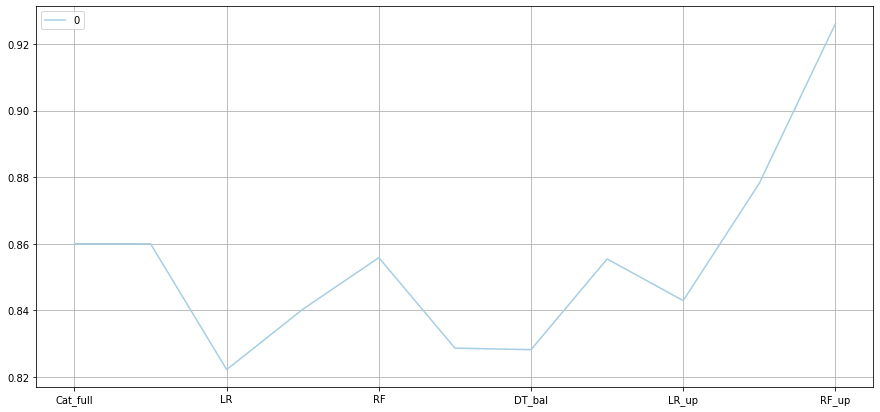

In [104]:
results=pd.DataFrame(data=scores,index=estim)
results.plot(figsize=(15,7))
plt.grid()
results

### Запуск на обучающей выборке.

In [105]:
model = models_list[10]

In [106]:
test_=test

In [107]:
test = test[['y_true','contract_duration', 'paymentmethod', 'monthlycharges','paperlessbilling','seniorcitizen',
               'totalcharges','onlinesecurity', 'techsupport','dependents','type','partner',
               'internetservice', 'onlinebackup','deviceprotection']]

In [108]:
test = pd.get_dummies(test, drop_first = True)
test_.head()

customerid  gender  seniorcitizen partner dependents            type  \
1204  6791-YBNAK    Male              0     Yes        Yes  Month-to-month   
2612  8198-RKSZG  Female              0     Yes        Yes  Month-to-month   
1488  8695-WDYEA    Male              0      No         No  Month-to-month   
5581  5271-YNWVR    Male              0     Yes        Yes        Two year   
5982  3721-CNZHX    Male              0      No         No        One year   

     paperlessbilling            paymentmethod  monthlycharges  totalcharges  \
1204               No  Credit card (automatic)           25.55        467.85   
2612               No  Credit card (automatic)           80.45       1137.05   
1488               No             Mailed check           51.25         51.25   
5581              Yes         Electronic check          113.15       7856.00   
5982               No             Mailed check           19.80        304.60   

      ... onlinesecurity onlinebackup deviceprotection techsupport  \
1204  ...             No           No               No          No   
2612  ...             No          Yes               No         Yes   
1488  ...            Yes           No               No          No   
5581  ...            Yes          Yes              Yes         Yes   
5982  ...             No           No               No          No   

     streamingtv streamingmovies multiplelines contract_duration  year_in  \
1204          No              No            No               549     2018   
2612         Yes             Yes           Yes               427     2018   
1488          No              No            No                31     2020   
5581         Yes             Yes           Yes              2071     2014   
5982          No              No            No               457     2018   

      y_true  
1204       0  
2612       0  
1488       0  
5581       1  
5982       0  

[5 rows x 21 columns]

In [109]:
y_test_pr = test['y_true']
x_test_pr = test.drop(['y_true'],axis=1)

Проведем масштабирование для логистической регрессии модели.

In [110]:
x_test_pr.columns

Index(['contract_duration', 'monthlycharges', 'seniorcitizen', 'totalcharges',
       'paymentmethod_Credit card (automatic)',
       'paymentmethod_Electronic check', 'paymentmethod_Mailed check',
       'paperlessbilling_Yes', 'onlinesecurity_Yes', 'techsupport_Yes',
       'dependents_Yes', 'type_One year', 'type_Two year', 'partner_Yes',
       'internetservice_Fiber optic', 'internetservice_No', 'onlinebackup_Yes',
       'deviceprotection_Yes'],
      dtype='object')

x_test_pr[numeric] = scaler.transform(x_test_pr[numeric])
x_train_pr

In [111]:
test['score'] = model.predict_proba(x_test_pr)[:,1]

In [112]:
roc_auc_score(test['y_true'],test['score'])

0.8509526756666412

In [113]:
test

y_true  contract_duration  monthlycharges  seniorcitizen  totalcharges  \
1204       0                549           25.55              0        467.85   
2612       0                427           80.45              0       1137.05   
1488       0                 31           51.25              0         51.25   
5581       1               2071          113.15              0       7856.00   
5982       0                457           19.80              0        304.60   
...      ...                ...             ...            ...           ...   
2484       0                365           20.50              0        255.50   
853        0                153           64.35              0        352.65   
4902       0                730           56.35              0       1381.20   
4548       1                668           84.30              0       1855.65   
294        0                365           19.70              0        220.35   

      paymentmethod_Credit card (automatic)  paymentmethod_Electronic check  \
1204                                      1                               0   
2612                                      1                               0   
1488                                      0                               0   
5581                                      0                               1   
5982                                      0                               0   
...                                     ...                             ...   
2484                                      0                               0   
853                                       0                               1   
4902                                      1                               0   
4548                                      0                               0   
294                                       0                               0   

      paymentmethod_Mailed check  paperlessbilling_Yes  onlinesecurity_Yes  \
1204                           0                     0                   0   
2612                           0                     0                   0   
1488                           1                     0                   1   
5581                           0                     1                   1   
5982                           1                     0                   0   
...                          ...                   ...                 ...   
2484                           1                     0                   0   
853                            0                     1                   1   
4902                           0                     0                   1   
4548                           1                     1                   0   
294                            1                     0                   0   

      techsupport_Yes  dependents_Yes  type_One year  type_Two year  \
1204                0               1              0              0   
2612                1               1              0              0   
1488                0               0              0              0   
5581                1               1              0              1   
5982                0               0              1              0   
...               ...             ...            ...            ...   
2484                0               1              0              0   
853                 1               0              0              0   
4902                1               0              0              0   
4548                0               0              0              0   
294                 0               0              0              0   

      partner_Yes  internetservice_Fiber optic  internetservice_No  \
1204            1                            0                   0   
2612            1                            0                   0   
1488            0                            0                   0   
5581            1         

In [114]:
x = ['contract_duration', 'paymentmethod', 'monthlycharges','paperlessbilling','totalcharges','onlinesecurity', 'techsupport',
     'seniorcitizen', 'dependents','type','partner','internetservice', 'onlinebackup','deviceprotection']

In [115]:
test['score_cat'] = models_list[1].predict_proba(test_[x])[:,1]
roc_auc_score(test['y_true'],test['score_cat'])

0.847838318180765

## Feature importances

In [116]:
model_cat.get_feature_importance(prettified=True)

Feature Id  Importances
0                type    36.897389
1     internetservice    26.499208
2   contract_duration    16.938719
3       paymentmethod     6.081029
4      monthlycharges     5.030374
5        totalcharges     4.551605
6    paperlessbilling     1.885747
7         techsupport     0.572582
8          dependents     0.410409
9      onlinesecurity     0.339175
10       onlinebackup     0.324914
11      seniorcitizen     0.284783
12   deviceprotection     0.106188
13            partner     0.077878

## Shap

In [117]:
import shap
shap.initjs()

In [120]:
explainer = shap.TreeExplainer(model_cat)
shap_values = explainer.shap_values(test_[x])

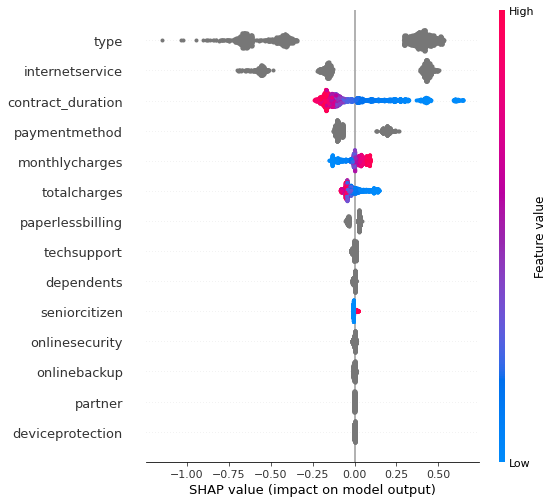

In [121]:
shap.summary_plot(shap_values, test_[x])

**Вывод по summary_plot** Что мы видим: 
* самым важным является признак contract_duration(длительность контракта)
* затем monthlycharges(размер ежемессячного платежа)
* totalcharges(размер израсходованых средств).

**1.contract_duration:** чем меньше длительность контракта, тем больше вероятность того, что клиент уйдет, а значит модель даст 1 в таргете.

**2.monthlycharges:** чем больше ежемесячный платеж, тем выше вероятность того, что в таргете будет 1.

**3.totalcharges** чем меньше объем израсходованых средств тем выше веротность потери клиента.  

In [122]:
features = model_cat.get_feature_importance(prettified=True)['Feature Id'].values

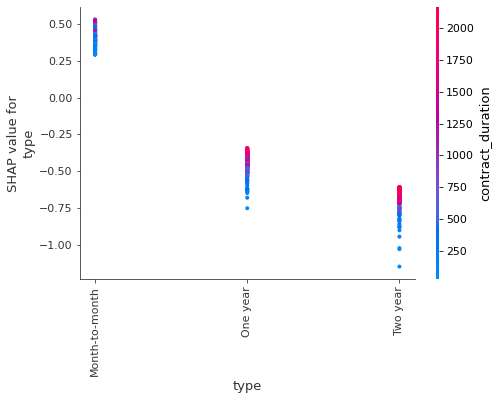

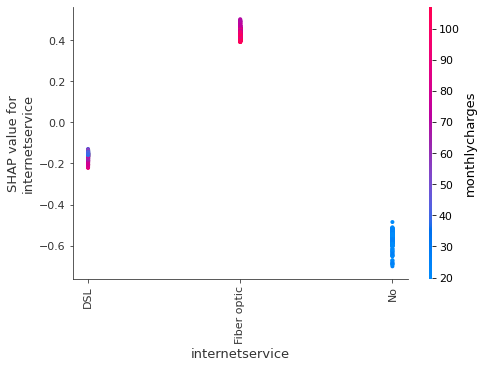

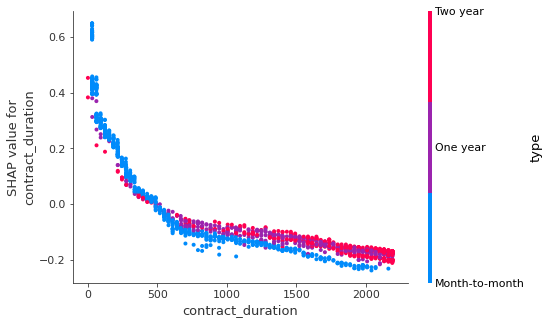

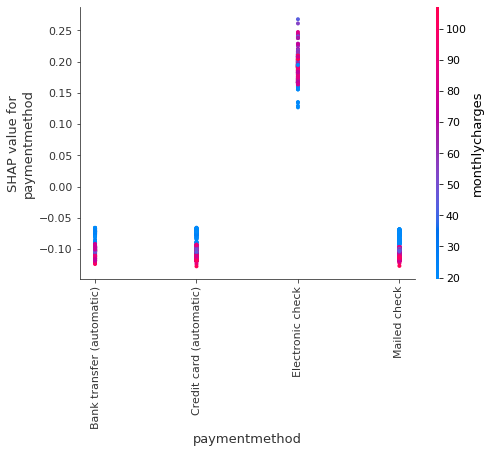

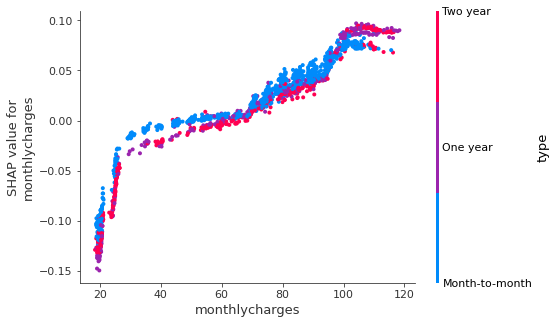

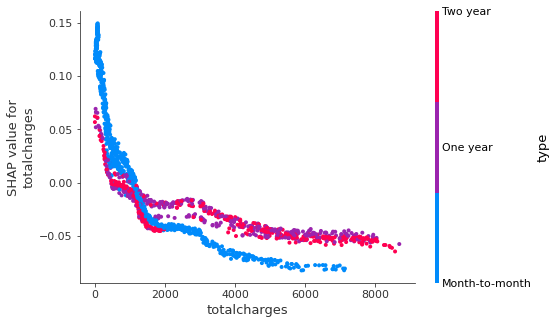

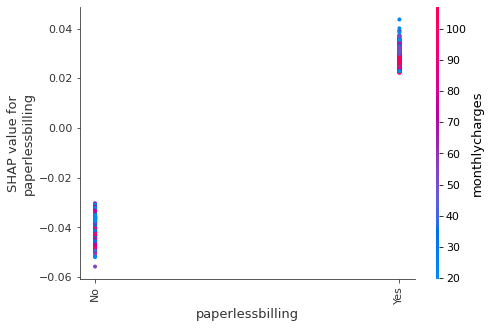

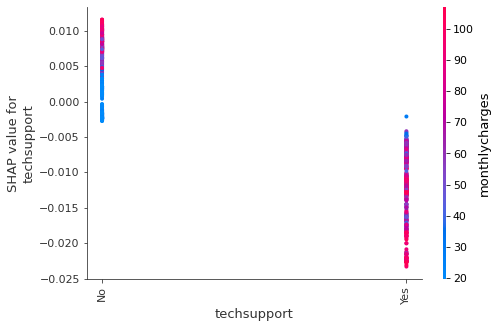

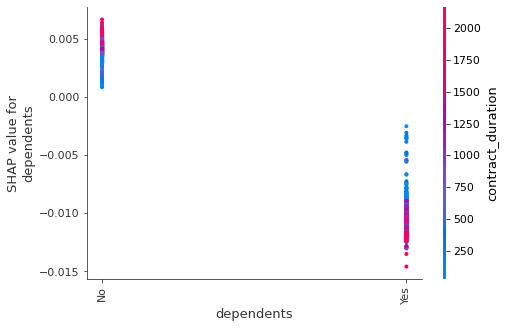

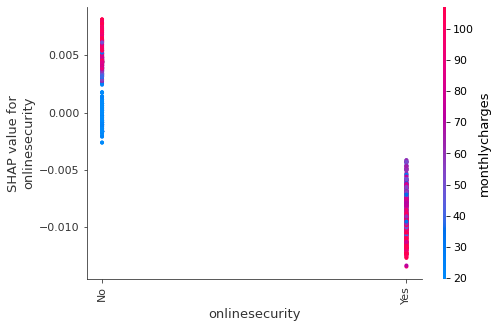

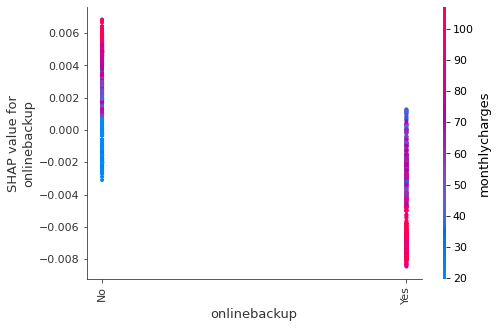

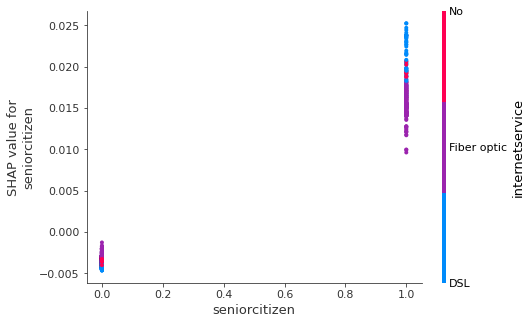

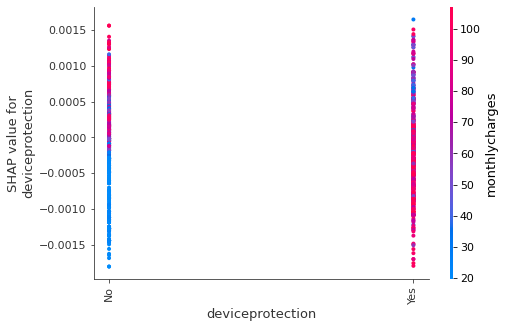

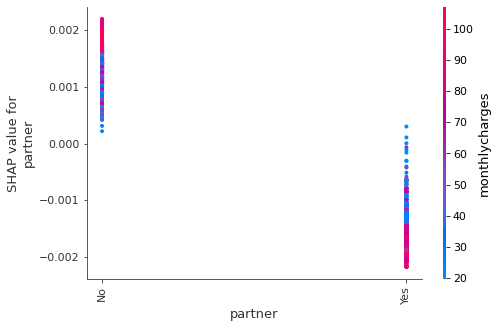

In [124]:
for feature in features:
  shap.dependence_plot(feature, shap_values, test_[x])

* **Зависимость monthlycharges от totalcharges:** стремится к линейной с 2мя перегибами. Чем больше monthlycharges тем больше  totalcharges. Уходят те у кого выше размер ежемесячных платежей.

* **Зависимость monthlycharges от totalcharges:** у клиентов с большим платежом выше веоятность ухода. У новых клиентов значительно выше вероятность покинуть операторатора.

* **Зависимость totalcharges от contract_duration:** Чем меньше объем израсходованных средств тем выше вероятность 1 в таргете и для таких клиентов длительность контракта низкая.


## Проверка модели на адекватность 

Адекватность модели проверим с помощью DummyClassifier. Посмотрим, какие значения он нам выдаст.

In [125]:
dummy = DummyClassifier(strategy='most_frequent').fit(x_train_pr,y_train_pr)
test['score_dummy'] = dummy.predict_proba(x_test_pr)[:,1]
print('roc_auc_score: ', roc_auc_score(y_test_pr, test['score_dummy']))

roc_auc_score:  0.5


**Вывод** Полученное значение roc_auc c помощью DummyClassifier = 0.5, значительно ниже нашего, значит, наша работа проделана не даром.

## Отчет. Задача оттока клиентов. Телеком. 

**Аннотация**
Использованы методы машинного обучения для оценки оттока клиентов оператора связи «Ниединогоразрыва.ком». Для решения такой задачи были использованы следующие модели: CatBoostClassifier, LogisticRegression, DecisionTreeClassifier и RandomForestClassifier. Данные были не сбалансированы по целевому признаку. Обучении проводилось, как с помощью методов улучшающих балансировку, так и без них Целевой метрикой в данном исследовании была ROC_AUC. Лучшей стала модель RandomForestClassifier(min_samples_leaf=2, n_estimators=2000, random_state=31022) с метрикой ROC-AUC 0.93 на обучающем наборе данных. На тестовом наборе была получена ROC-AUC 0.85 . Accuracy модели 0.81, precision ухода клиентов составляет 0.64. Полнота(recall ) и F1 - 0.65.

***


**Анализ данных:**


* Для работы были предоставлены персональные данные о некоторых клиентах, информация об их тарифах и договорах из разных источников: информация о договоре,персональные данные клиента, информация об интернет-услугах, информация об услугах телефонии. В общей сложности в выборке были данные о  7043 клиентах и 20 признаков, включая целевой. 2 признака было в форматах дат, которые преобразовали в datetime. 2 были вещественными. Остальные категориальные. 

* В выборке были следующие признаки: customerID - код клиента, BeginDate - дата, когда пользователь стал клиентом оператора, EndDate - дата указана не везде, type - тип оплаты, PaperlessBilling - электронный документ об оплате, PaymentMethod - оплата по электронному чеку, MonthlyCharges - размер ежемесячной оплаты, TotalCharges - всего оплачено средств, gender - пол клиента, SeniorCitizen - пенсионер, Partner - наличие супруга, dependents - наличие иждевенцев. InternetService - тип подключения к интернету. А также опции к интернет пакету: опция OnlineSecurity -  блокировка небезопасных сайтов, OnlineBackup - облачное хранилище файлов для резервного копирования данных, DeviceProtection - антивирус, TechSupport - выделенная линия технической поддержки. StreamingTV - стриминговое телевидение. StreamingMovies - каталог фильмов. А также опция связи: MultipleLines - наличие или отсутствие нескольких линий одновременно.

* Данные были из разных источников. Для продолжения работы их нужно было объединить.
          
                                         df_contract	7043  
                                         df_personal	7043  
                                         df_internet	5517  
                                         df_phone	6361  
  
* Вывод по длине выборок В contract и personal у нас одинаковое количество клиентов. В данных по пользователям интернета и стационарного телефона данных значительно меньше. Получается, что лишь часть пользователей использует и те и другие типы связи.
Названия признаков были указаны в разном регистре, чтобы не путаться в дальнейшем названия столбцов были сведены к нижнему регистру.  
* При проверке типов данных обнаружено, что seniorcitizen бинарна, принимает значения 0 или 1. При этом являясь категориальной переменной. Проведена замена типа данных в датах: begindate и enddate с object на datetime, а totalcharges с  object на float. Исправить тип в totalcharges сразу не получилось. Видимо, в данных были пробелы и прочие знаки. Столбец очищен  и преобразован в вещественный.  
*  После корректировки формата begindate и enddate построено распределение значений данных признаков.
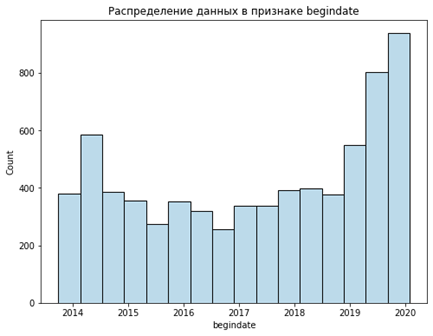
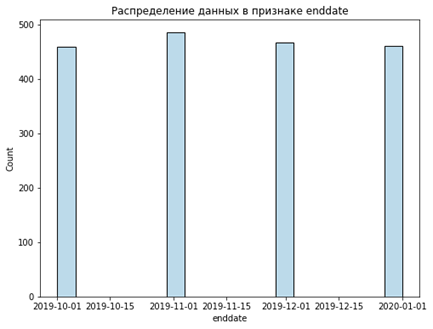
* Судя по датам, клиенты уходили примерно в одинаковом количестве 4 месяца до выгрузки. Это октябрь, ноябрь и декабрь 2019 года + январь 2020 года. Данных по февралю 20 года у нас нет, так как данные выгружены 01.02.20г. Уходило немного менее 500 человек. Получается, что с октября 19 года, люди стали уходить. ВОзможно, у конкурента появилось какое-то выгодное предложение, либо наш сервис перестал устраивать. Может быть, были какие-то сбои.  
* Были проанализированы те клиенты, которые ушли по параметру типу оплаты и PaperlessBilling. 
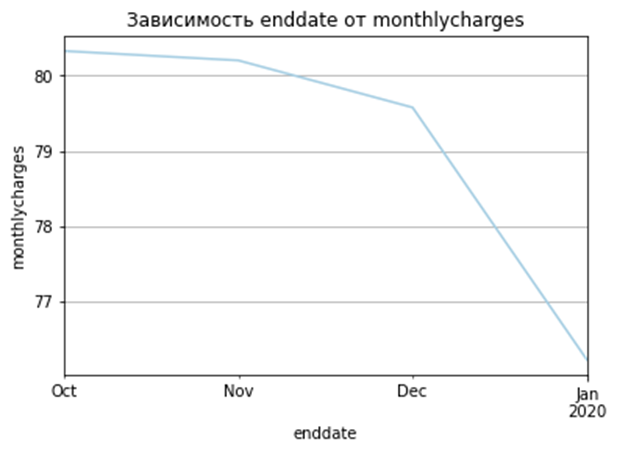
                                         count       mean  median                              
                                         2019-10-01    458  75.827948  80.325  
                                         2019-11-01    485  75.012887  80.200  
                                         2019-12-01    466  74.325536  79.575  
                                         2020-01-01    460  72.575435  76.225  
* Вывод по зависимости ухода от monthlycharges: получается, что уходили те, кто платить в среднем около 75 у.е. в месяц.
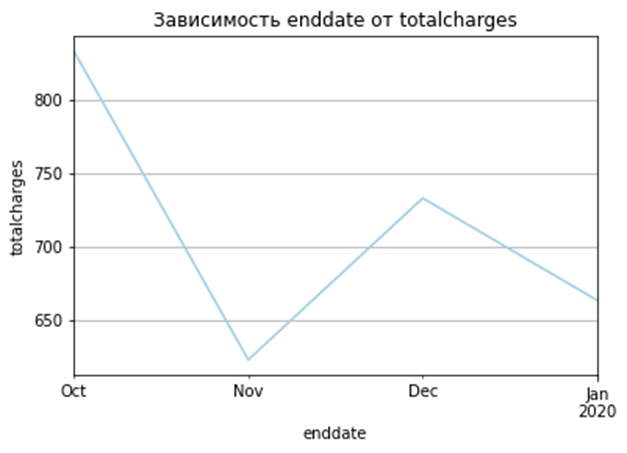
                                         count         mean   median                           
                                         2019-10-01    458  1619.448035  833.125  
                                         2019-11-01    485  1440.232577  622.900  
                                         2019-12-01    466  1584.518348  732.925  
                                         2020-01-01    460  1487.655109  663.325  
* Вывод по зависимости ухода от totalcharges: ушли в среднем те, кто успели воспользоваться услугами на сумму около 700 у.е.
* Построены графики зависимостей признаков для клиентов, которые ушли из компании:
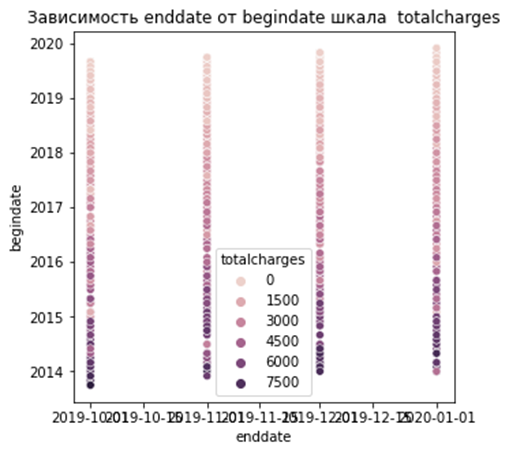
* Тут ясная зависимость уменьшения объема израсходованных средств на услуги от даты начала договора. Что видно по цвету, так это то, что большая часть значений в светлом поле до 3000  у.е.
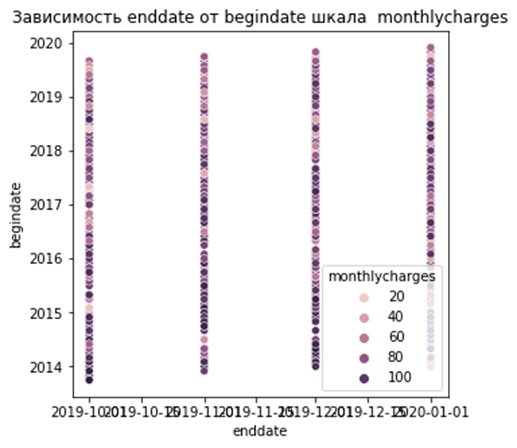
* Зависимость enddate от begindate в шкале monthlycharges свидетельствует о том, что большая часть клиентов, ушедших от оператора платила более 80 у.е. Значения около 20-40 у.е. смотрятся вкраплениями.
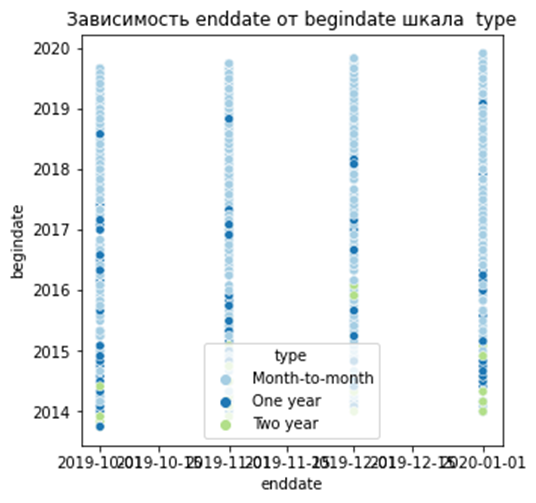
* Что касательно типа оплаты, абсолютное большинство это договоры с ежемесячной оплатой. 
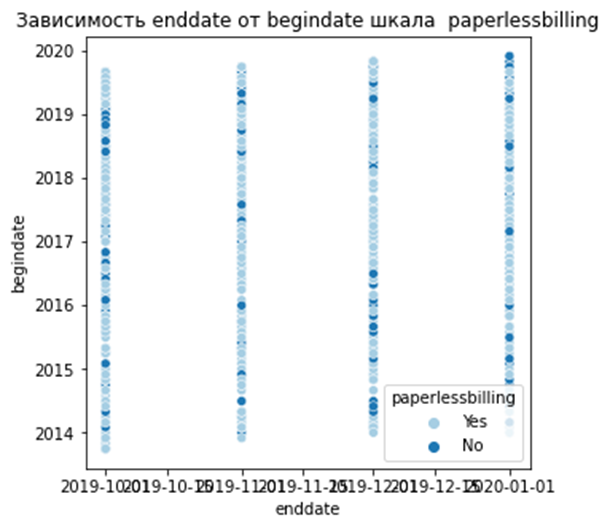
* Абсолютное большинство клиентов, которые уходят это клиенты, которые получают электронный документ об оплате.
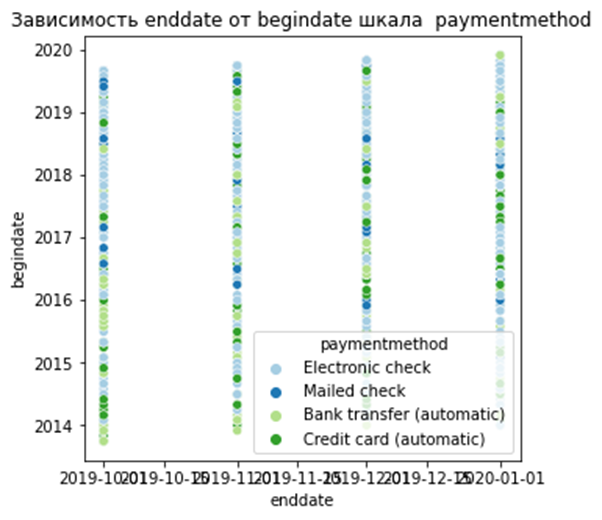
* По типам оплаты, что-то однозначно очевидное сложно сказать . Вряд ли есть какая-то зависимость от этого признака.

**Работа с непрерывными переменными.**

* Распределение totalcharges и monthlycharges:
                                               	monthlycharges	totalcharges  
                                         count	7043.000000	 7043.000000    
                                         mean	64.761692	 2279.734304    
                                         std	30.090047	 2266.794470    
                                         min	18.250000	 0.000000    
                                         25%	35.500000	 398.550000    
                                         50%	70.350000	 1394.550000    
                                         75%	89.850000	 3786.600000    
                                         max	118.750000	 8684.800000    
*Возможно, что не все клиенты-новички платят по минимальной ставке, в принципе, у нас сейчас именно так.
Распределение значений totalcharges и monthlycharges.
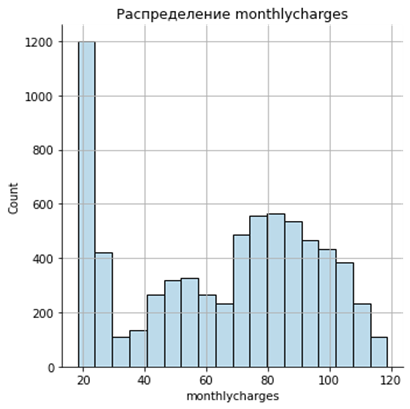

* **Выводы по распределению  totalcharges и monthlycharges:** Средние ежемесячных расходов и общих затрат составляют, соответственно, 64.76 и 2283.30 у.е. Серьезный пик в ежемесячных платежах находится в значении около 20 у.е. А в общих затратах у 20.

**Оценка категориальных признаков:**
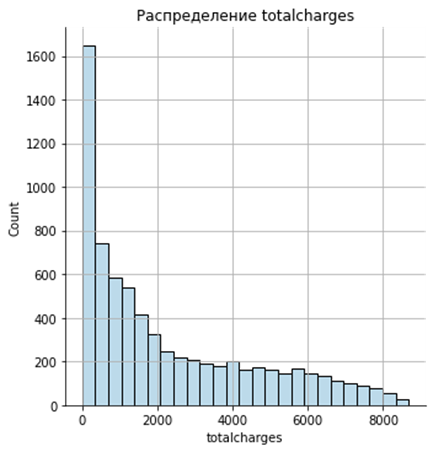
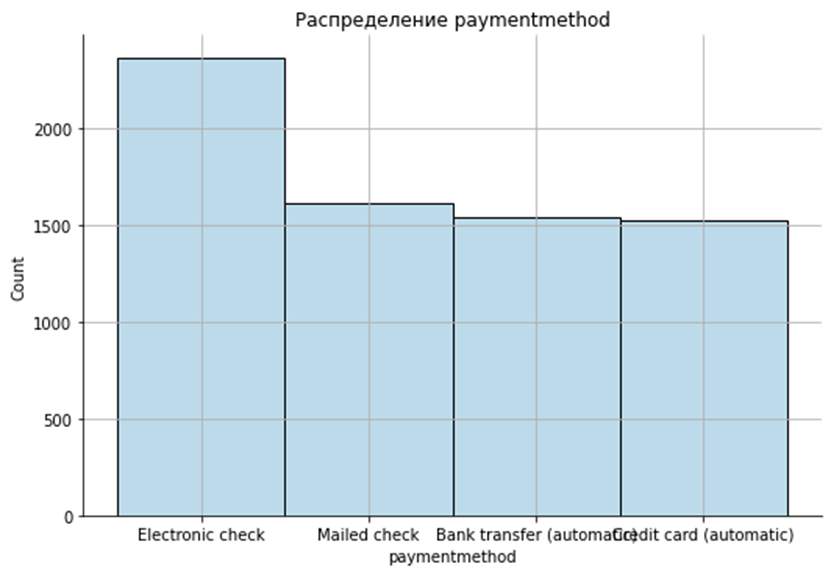
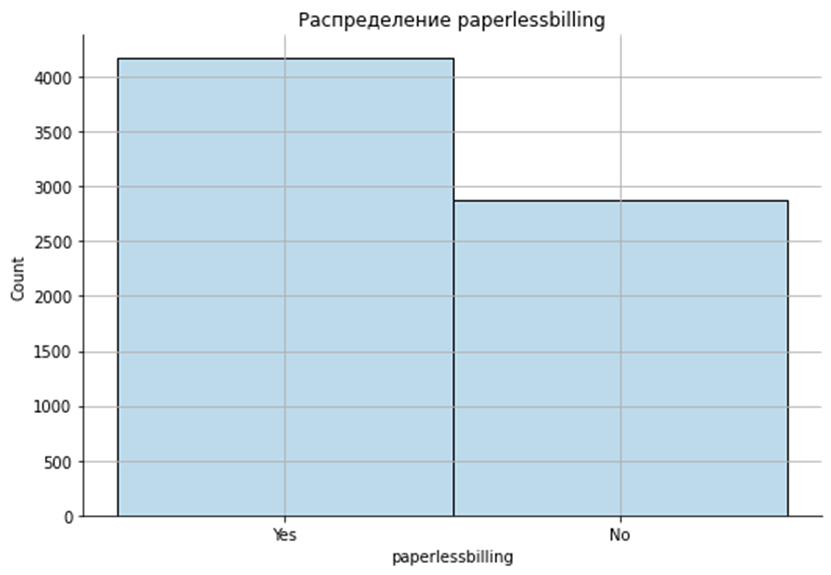
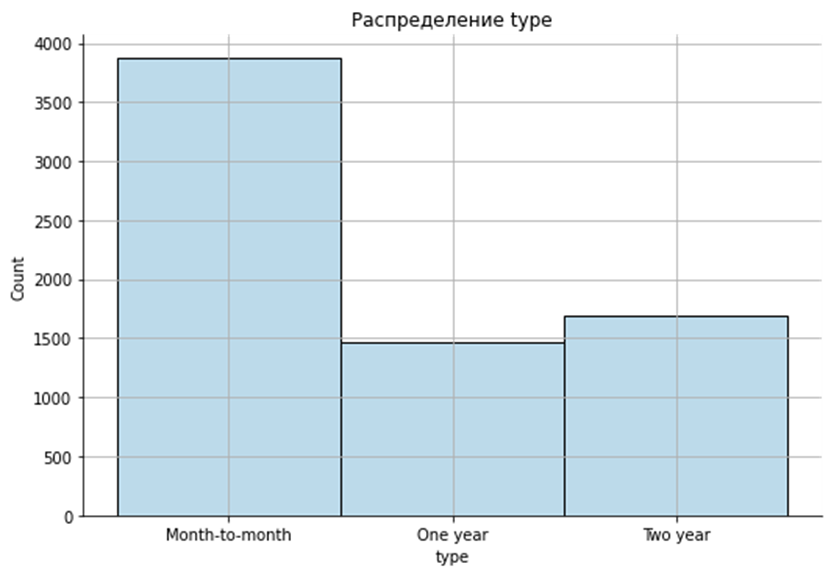
* **Выводы по категориальным признакам источника контракты:**
●	Тип оплаты 55% все договоров оформлены с ежемесячной оплатой. 20% с оплатой ежегодной. И 24% с оплатой раз в 2 года.  
●	Электронный документ об оплате Практически 60% получают чеки, тогда как 40% они не требуются.  
●	Способ оплаты лидером по оплатам - 33% занимают электронные квитанции. Остальные способы оплаты популярны в равной степени.   Около 21-22%: почтовые квитанции, автоматические оплаты с карт и банковские переводы.  
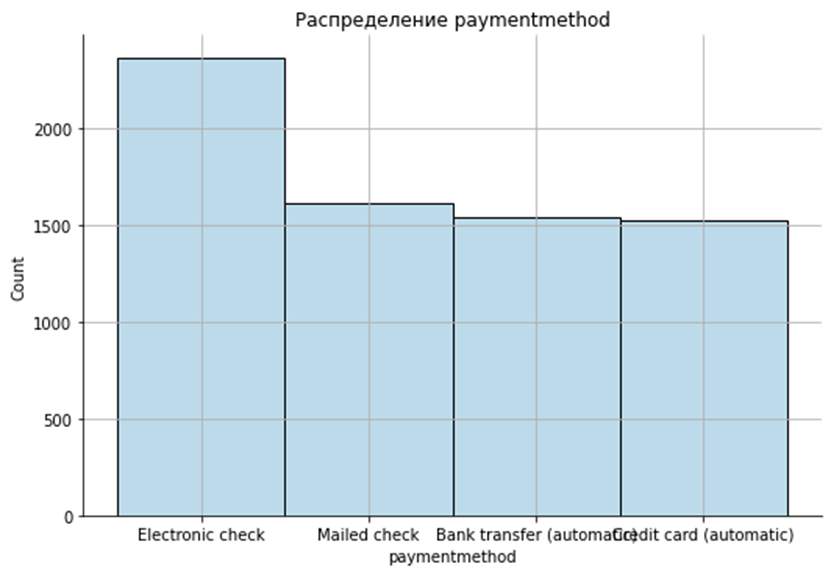
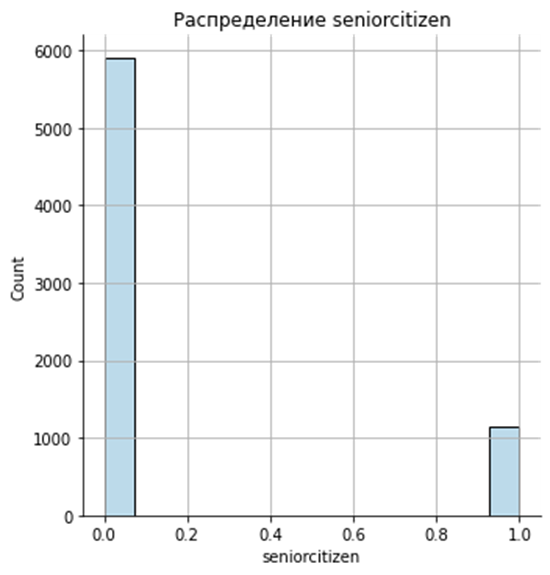
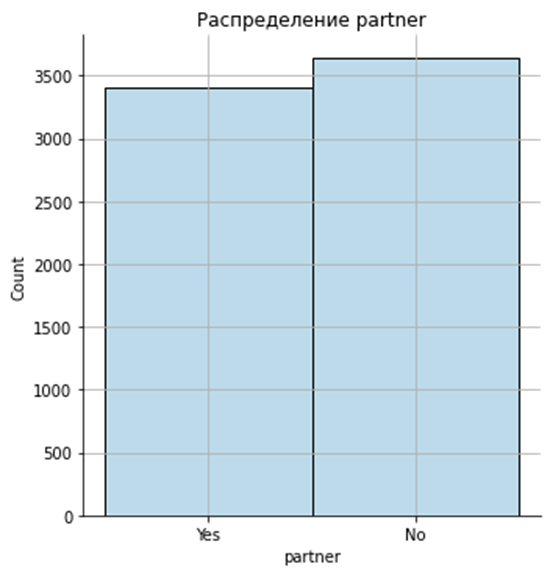
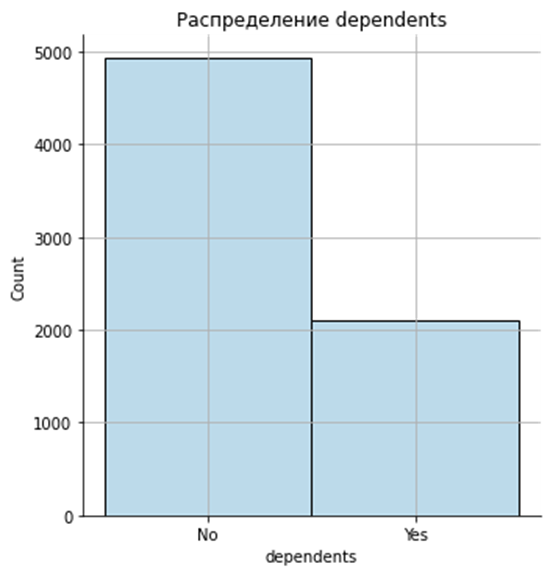
* **Выводы по категориальным признакам источника персональные данные:**
●	Пол Деление по полам примерно равнозначное. 50% женщин и 50% мужчин.  
●	Электронный документ об оплате Практически 60% получают чеки, тогда как 40% они не требуются.  
●	Способ оплаты лидером по оплатам - 33% занимают электронные квитанции. Остальные способы оплаты популярны в равной степени.   Около 21-22%: почтовые квитанции, автоматические оплаты с карт и банковские переводы.  
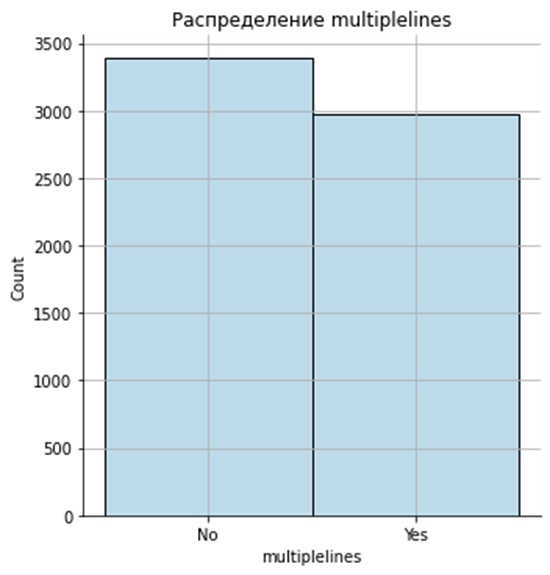
* **Выводы по категориальным признакам источника персональные данные:**  
●	Возможность ведения параллельных линий во время звонка 47% пользователей имеют такую возможность.  
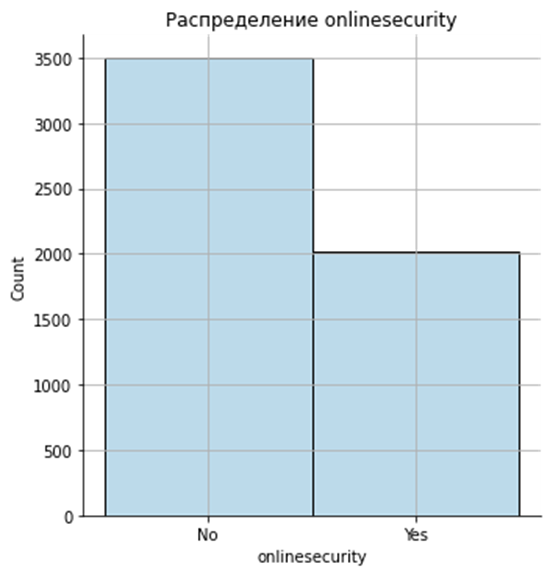
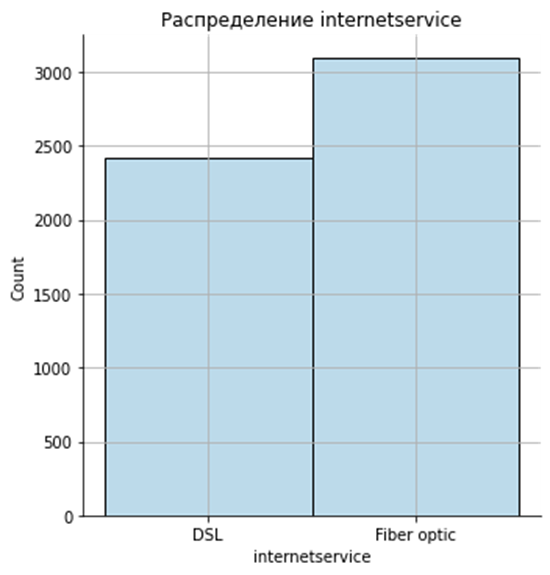
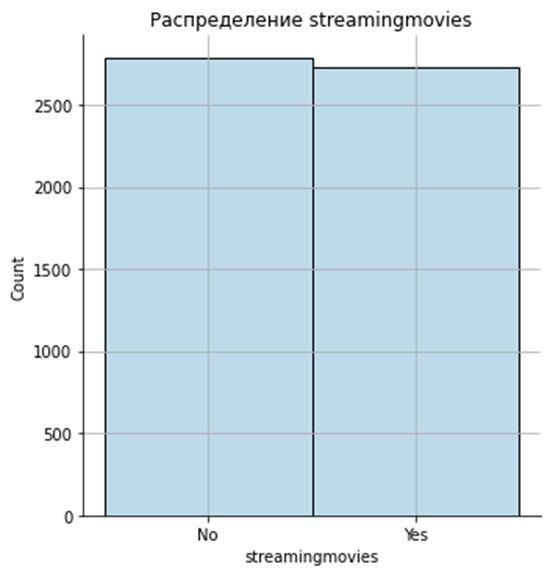
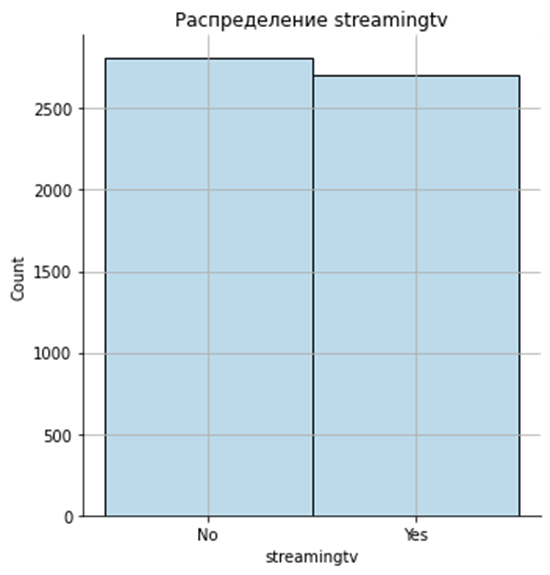
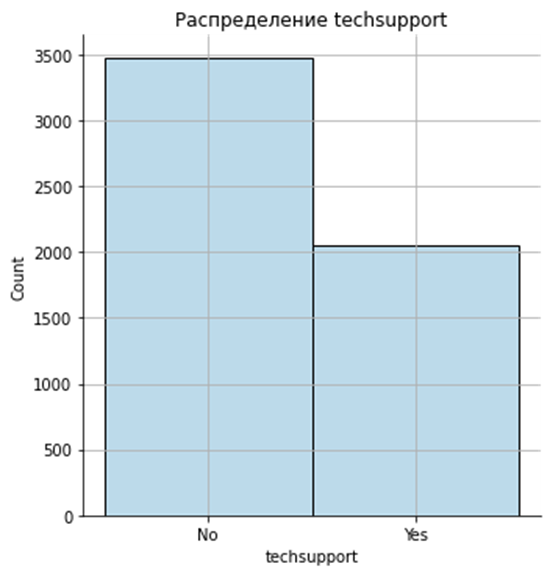
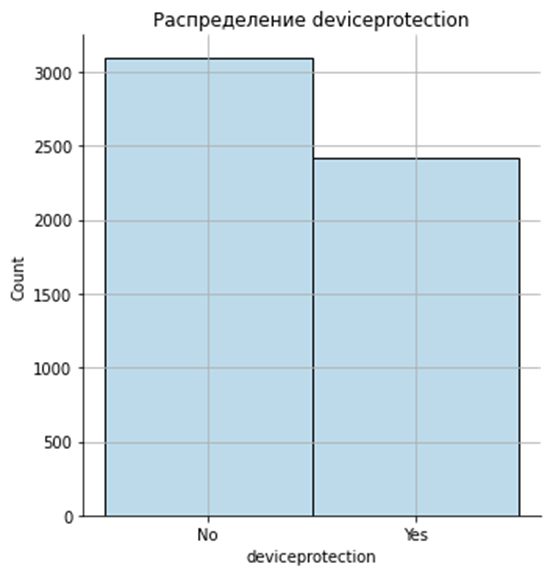
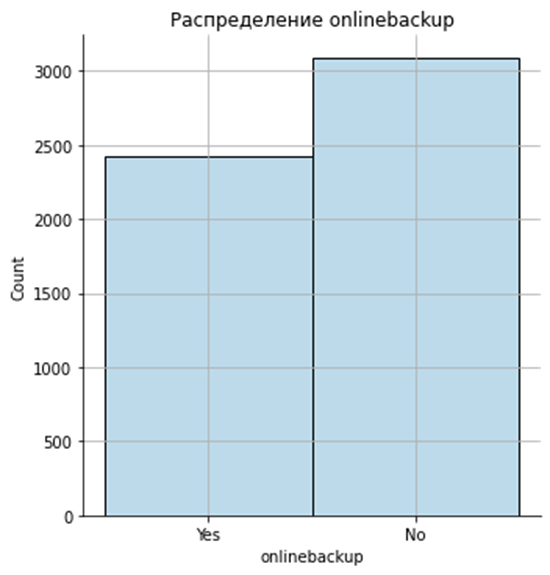
* **Категориальные признаки в источнике сведений использваний интернета:**
●	Подключение интернета подключение через оптоволоконный кабель Fiber optic у 56% пользователей, у остальных через телефонную линию DSL.  
Не более 50% пользователей подключены к доп услугам:
●	Блокировка небезопасных сайтов есть только у 36% пользователей.  
●	Облачное хранилище файлов и Антивирус есть только у 44% пользователей.  
●	Выделенная линия технической поддержки есть только у 37% пользователей.  
●	Стриминговое телевидение и Каталог фильмов более популярны и практически 50% пользуются этой услугами.  

***

**Подготовка данных для машинного обучения:**


Данные из 4х источников объединили в один dataframe.


Значение в Enddate соответствует дате потери клиента. Данные выгружали первое февраля 2020 года. Сделан новый признак длительность контракта contract duration как разницу между begindate и enddate. Для этого, там, где не указано даты в Enddate  - укажем 1.02.20.


Целевой признак - уход клиента. Для тех клиентов где был изначально указан enddate присвоено  значение таргета - 1. Там же, где не было указано даты ухода в таргете 0.


Соотношение 0 и 1 в таргете:

                                               	0    0.73463
                                               	1    0.26537
                                                
                                                
                                                
Мы будем обучать модель без борьбы с дисбалансом, с помощью указания параметра class_weight='balanced', а также проводя upsampling с помощью техники SMOTE. Сравним результаты.



Удаляем ненужные признаки:  'customerID','EndDate', 'BeginDate'.  



Проверяем выборку на пропуски.   


Пропуски в данных у 21.6% пользователей в след признаках:internetservice, onlinesecurity, onlinebackup,deviceprotection,techsupport,streamingtv, streamingmovies, multiplelines. Данных нет, так как пользователь не пользуется услугой. Все пустые значения заполним No. 



Деление выборки на обучающую и тренировочну..Проверен баланс класов при разделении выборок. Он сохранен.



Коэффициент phik.

Для оценки корреляции признаков был использован коэффициент phik.

 
customerid           1.000000  
y_true               1.000000  
contract_duration    0.462353  
paymentmethod        0.462098  
monthlycharges       0.354175  
year_in              0.348037  
paperlessbilling     0.309623  
totalcharges         0.273188  
techsupport          0.252553  
seniorcitizen        0.252168  
dependents           0.249871  
type                 0.247579  
onlinesecurity       0.245887  
partner              0.222036  
internetservice      0.197782  
onlinebackup         0.135824  
deviceprotection     0.102760  
streamingtv          0.099400  
streamingmovies      0.098003  
multiplelines        0.071226  
gender               0.018336  


**Вывод по Phik** наибольшей связью с уходом клиента является contract_duration. Тут также появился атрибут paymentmethod(тип оплаты) с коэффициентом 0.455, monthlycharges phik оценивает значительно выше и это 0.359. Далее идут paperlessbilling, totalcharges, onlinesecurity и techsupport.


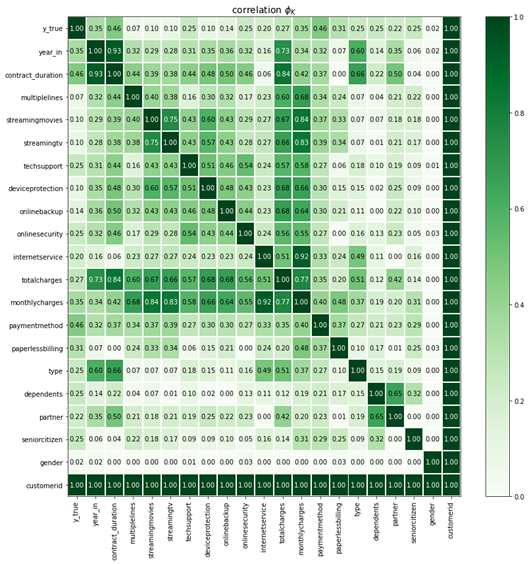

По полученным коэффициентам корреляции был удален признак , так как он был  мультиколлинеарным.
В работе использована логистическая регрессия для которой критично наличие таких признаков выборке. По полученным данным были отброшены признаки с наименьшим коэффициентом(менее 0,20).

***


**Машинное обучение:**


CatBoost была запущена на всех признаках,  а также на уменьшенном количестве с корректировкой по коэффициенту Phik: y_true, contract_duration, paymentmethod, monthlycharges, paperlessbilling,'totalcharges, onlinesecurity, techsupport, seniorcitizen, dependents, type, partner, internetservice, onlinebackup, deviceprotection.


Для моделей LogisticRegression, DecisionTreeClassifier и RandomForestClassifier также использовался усеченный перечень признаков. Было проведено кодирование категориальных признаков с помощью One-Hot-Encoding.


Для логистической регрессии проведено масштабирование monthlycharges и totalcharges.    
Перебор параметров осуществлялся кросс-валидацией с помощью GridSearchSV.


Был протестирован следующий **перечень моделей для которых получили соответствующие ROC-AUC** 





<catboost.core.CatBoostClassifierat 0x7fcb5e57da50>,                                                               **0,86**  

<catboost.core.CatBoostClassifier at 0x7fcb5e573f90>,	                                                             **0,86**  

LogisticRegression(max_iter=1500, random_state=31022, solver='sag'),	                                              **0,82**  

DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, random_state=31022)                                        	**0,84**  

RandomForestClassifier(min_samples_leaf=5, n_estimators=2000, n_jobs=-1, random_state=31022)	                      **0,86** 
LogisticRegression(class_weight='balanced', max_iter=1500, random_state=31022, solver='sag')	                          **0,83 

DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=4, random_state=31022)                **0,83** 

RandomForestClassifier(class_weight='balanced', min_samples_leaf=6, n_estimators=1500, n_jobs=-1, random_state=31022) **0,86**

LogisticRegression(max_iter=1500, random_state=31022, solver='sag')                                                **0,84**

DecisionTreeClassifier(max_depth=10, min_samples_leaf=6, random_state=31022)                                       **0,88**

RandomForestClassifier(min_samples_leaf=2, n_estimators=2000, random_state=31022)	                                  **0,93**  




* **Лучшей стала модель RandomForestClassifier(min_samples_leaf=2, n_estimators=2000, random_state=31022)** с метрикой ROC-AUC  0.93 на обучающем наборе данных. На тестовом наборе была получена ROC-AUC 0.85 . Accuracy модели 0.81,  precision ухода клиентов составляет 0.64. Полнота(recall ) и F1 -  0.65. 



**Classification report лучшей модели:**  
             precision    recall  f1-score   support  

           0       0.87      0.87      0.87      1294  
           1       0.64      0.65      0.65       467  

    accuracy                           0.81      1761  
    
    
    
***
 
**Анализ важности признаков**

По итогам моделирования  проведен анализ важности признаков с помощью библиотеки Shap.

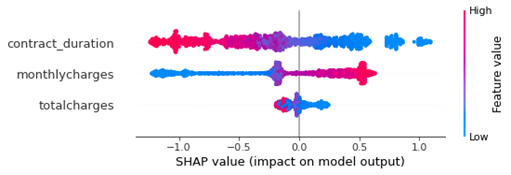  


Самый серьезный вклад вносит признак contract duration. Чем меньше длительность контракта, тем больше вероятность того, что клиент уйдет, а значит модель даст 1 в таргете.
Затем monthlycharges: чем больше ежемесячный платеж, тем выше вероятность того, что в таргете будет 1.
Третьим totalcharges чем меньше объем израсходованных средств тем выше вероятность потери клиента.

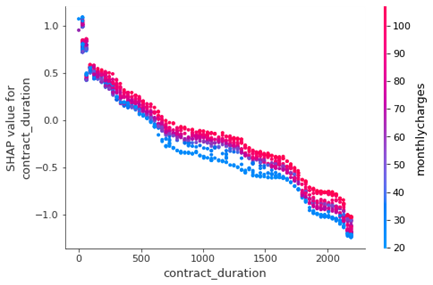
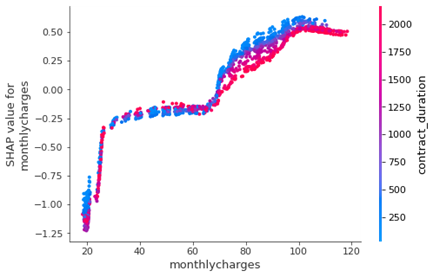
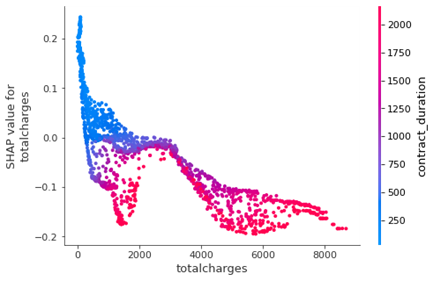


Зависимость monthlycharges от totalcharges: стремится к линейной с 2мя перегибами. Чем больше monthlycharges тем больше totalcharges. Уходят те у кого выше размер ежемесячных платежей.


Зависимость monthlycharges от totalcharges: у клиентов с большим платежом выше веоятность ухода. У новых клиентов значительно выше вероятность покинуть операторатора.


Зависимость totalcharges от contract_duration: Чем меньше объем израсходованных средств тем выше вероятность 1 в таргете и для таких клиентов длительность контракта низкая.
